In [2]:
import pandas as pd
import numpy as np
import random
from datetime import date, time
from IPython.display import display
pd.options.display.max_columns = None
import scipy.stats as stats
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.genmod.families import Binomial
import researchpy as rp
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import rpy2.robjects as ro
import rpy2.robjects.pandas2ri as pandas2ri
pandas2ri.activate()
from patsy import dmatrix
from pymer4.models import Lmer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression

## Data transformation functions

In [2]:
#function for creating lists of SIDs
def listify(cell):
    if pd.isna(cell):
        return []
    else:
        cell = str(cell)
        cell = cell.replace(" ", "")
        listy = list(cell.split(","))
        return listy

In [3]:
#function for correcting double counts for same concept
def no_double(component, *args):
    component = pd.DataFrame(component)
    count = 1
    for data in args:
        if not isinstance(data, pd.Series):
            for column in data:
                name = 'arg' + str(count)
                column_series = pd.Series(column)
                component[name] = column_series
                count += 1
        else:
            component = pd.concat((component, data), axis=1)
    
    component['sum'] = component.iloc[:, 1:].sum(axis=1)

    updated_component = []
    
    for row in component.iterrows():
        if row[1][0] >0 and row[1][-1] >0:
            updated_component.append(0)
        elif row[1][0] == 1 and row[1][-1] == 0:
            updated_component.append(1)
        else:
            updated_component.append(0)
    
    return updated_component

In [4]:
#function for converting operative severity to numbers
def op_severity(severity):
    updated_severity = []
    
    for item in severity:
        item = str(item)
        item = item.lower()
        if 'complex' in item:
            updated_severity.append(5)
        elif 'xmajor' in item:
            updated_severity.append(4)
        elif 'major' in item:
            updated_severity.append(3)
        elif 'intermediate' in item:
            updated_severity.append(2)
        elif 'minor' in item:
            updated_severity.append(1)
        else:
            updated_severity.append(3)
            print('Unknown operation severity code : '+item)
            
    return updated_severity

In [5]:
#function for calculating CCI
def cci(data):
    CCI = []
    for row in data.iterrows():
        score = 0
        if row[1]['cardiac'] == 1:
            score += 1
        if row[1]['kidney'] == 1:
            score += 2
        if row[1]['liver'] == 1:
            score += 2
        if row[1]['neuro'] == 1:
            score += 2
        if row[1]['pulm'] == 1:
            score += 1
        if row[1]['dementia'] == 1:
            score += 1
        if row[1]['diabetes_uncomp'] == 1:
            score += 1
        if row[1]['comp_diabetes'] == 1:
            score += 2
        if row[1]['malignancy_no_met'] == 1:
            score += 2
        if row[1]['metastasis'] == 1:
            score += 6
        if row[1]['pvd'] == 1:
            score += 1
        if row[1]['rheum'] == 1:
            score += 1
        if row[1]['pulm'] == 1:
            score += 1
        CCI.append(score)
    
    return CCI

In [6]:
#functions for identifying post-op crit care for patients admitted to level 0 & 1
def crit_care(p):
    updated_crit_care = []
    for row in p.iterrows():
        if row[1]['cancelled'] == 1:
            updated_crit_care.append(0)
        elif row[1]['actual_lvl'] > 1:
            updated_crit_care.append('Not applicable')
        elif row[1]['los_23'] >0:
            updated_crit_care.append(1)
        else:
            updated_crit_care.append(0)
    return updated_crit_care

def crit_care_7d(p, ts):
    updated_crit_care = []
    for row in p.iterrows():
        if row[1]['cancelled'] == 1: #cancelled
            updated_crit_care.append(0)
        elif row[1]['actual_lvl'] > 1: #level 2-3 post-op
            updated_crit_care.append('Not applicable')
        elif row[1]['los_23'] >0: #LOS in levels 2-3 >0
            SID = row[0]
            date = row[1]['kts']
            date = date.replace(hour=0, minute=0, second=0)
            date_position = ts.index.get_loc(date)
            date_7 = date_position + 7
            check = ts.iloc[date_position:date_7, [25, 29]]
            check = check['adm_7d_lvl2'] + check['adm_7d_lvl3']
            count = 0
            for row in check:
                if SID in row:
                    updated_crit_care.append(1)
                    count += 1
                    break
            if count == 0:
                updated_crit_care.append(0)
        else:
            updated_crit_care.append(0)
    return updated_crit_care

In [7]:
#function for adding dates of death from encounter end
def died_date(died, date, encounter_end):
    checker = pd.concat((died, date, encounter_end), axis=1)
    updated_date = []
    
    for row in checker.iterrows():
        if row[1]['died'] == 0:
            updated_date.append(0)
        if row[1]['died'] == 1:
            if row[1]['died_date'] == 0:
                updated_date.append(pd.to_datetime(row[1]['encounter_end'], errors='coerce', infer_datetime_format=True))
        if row[1]['died'] == 1:
            if row[1]['died_date'] != 0:
                updated_date.append(pd.to_datetime(row[1]['died_date'], errors='coerce', infer_datetime_format=True))
    return updated_date

In [8]:
#function for calculating stepdowns
def stepdowns(proposed, actual, dataset):
    stepdown_list = []
    for row in dataset.iterrows():
        if row[1]['cancelled'] == 1:
            stepdown_list.append(np.nan)
        elif row[1]['proposed_lvl'] not in proposed:
            stepdown_list.append(np.nan)
        elif row[1]['actual_lvl'] in actual:
            stepdown_list.append(1)
        else:
            stepdown_list.append(0)
    
    return stepdown_list

def stepdowns_nobed(proposed, actual, dataset):
    stepdown_list = []
    for row in dataset.iterrows():
        if row[1]['cancelled'] == 1:
            stepdown_list.append(np.nan)
        elif row[1]['proposed_lvl'] not in proposed:
            stepdown_list.append(np.nan)
        elif row[1]['difference_nobed'] == 0:
            stepdown_list.append(0)
        elif row[1]['actual_lvl'] in actual:
            stepdown_list.append(1)
        else:
            stepdown_list.append(0)
    
    return stepdown_list

In [9]:
#function for loading data for each hospital
def data_load(p, ts):

    #loading patient_crf
    patient = pd.read_excel("C:\\Users\\chris\\Documents\\Job Documents\\Portfolio Evidence\\Research\\Post-Operative Critical Care Beds Project\\Results Data\\Cleaned CRFs\\"+p, sheet_name=None)
    try:
        patient = pd.DataFrame(data=patient['Sheet1'])
    except:
        print('The sheet isnt called Sheet1, rename this')
        
    patient.columns = patient.iloc[2]
    patient = patient.iloc[3:]
    patient.columns.name = None
    
    patient = patient.iloc[:len(patient['sid_number'].explode().dropna())]
    
    patient.fillna(value=0, inplace=True)
    
    if patient.columns[0] == 'hospital_number':
        patient = patient.iloc[:, 1:]
    
    patient = patient.rename(columns={'risk_score': 'risk_score_patient'})
    
    if 'rhem' in patient.columns:
        patient = patient.rename(columns={'rhem': 'rheum'})
        
    if 'scheduled_date' in patient.columns:
        merged = []
        for row in patient.iterrows():
            row_data = row[1]
            time_merge = pd.Timestamp.combine(row_data['scheduled_date'], row_data['scheduled_start'])
            merged.append(time_merge)
        merged_series = pd.DataFrame(merged)
        merged_series = merged_series.set_index(patient['sid_number'])
        patient['scheduled_start'] = merged_series
        patient = patient.drop('scheduled_date', axis=1)
        
    patient = patient.set_index('sid_number')
    patient.index.name = None
        
    code_num = str(patient.index[0])
    code = code_num[:5]
    
    print('Loading patient CRF for: '+code)
    
    patient['diabetes_uncomp'] = no_double(patient['diabetes'], patient['comp_diabetes'])
    patient['diabetes'] = [1 if (row[1]['diabetes'] + row[1]['comp_diabetes']) > 0 else 0 for row in patient.iterrows()]
    patient['malignancy_no_met'] = no_double(patient['malignancy'], patient['metastasis'])
    patient['malignancy'] = [1 if (row[1]['malignancy'] + row[1]['metastasis']) > 0 else 0 for row in patient.iterrows()]
    patient['clin_j'] = no_double(patient['clin_j'], (patient['sop'], patient['cpet'], patient['risk_score_patient']))
    patient['op_severity'] = op_severity(patient['op_severity'])
    try:
        patient['died_date'] = died_date(patient['died'], patient['died_date'], patient['encounter_end'])
    except:
        print("There has been an error updating the date of death for some of the patients in dataset: "+code)
    patient['BAME'] = patient['asian'] + patient['black'] + patient['mixed'] + patient['other']
    patient['CCI'] = cci(patient)
    patient['los_23'] = patient['los_2'] + patient['los_3']
    patient['los_recount'] = patient['los_0'] + patient['los_1'] + patient['los_2'] + patient['los_3']
    patient['1stepdowns'] = stepdowns([1], [0], patient)
    patient['1stepdowns_nobed'] = stepdowns_nobed([1], [0], patient)
    patient['23to0stepdowns'] = stepdowns([2, 3], [0], patient)
    patient['23to0stepdowns_nobed'] = stepdowns_nobed([2, 3], [0], patient)
    patient['23to1stepdowns'] = stepdowns([2, 3], [1], patient)
    patient['23to1stepdowns_nobed'] = stepdowns_nobed([2, 3], [1], patient)
    patient['ward_stepdowns'] = stepdowns([1, 2, 3], [0], patient)
    patient['ward_stepdowns_nobed'] = stepdowns_nobed([1, 2, 3], [0], patient)
    
    patient['enhanced_care_ref'] = [1 if row[1]['proposed_lvl'] == 1 else 0 for row in patient.iterrows()]
    patient['enhanced_care_adm'] = [1 if row[1]['actual_lvl'] == 1 else 0 for row in patient.iterrows()]
    
#    risk_score_list = []
#    for row in patient.iterrows():
#        if (row[1]['risk_score_patient'] == 1) and ((row[1]['mortality_score'] + row[1]['morbidity_score']) == 0):
#            risk_score_list.append(row[0])
#    if len(risk_score_list) > 0:
#        print('List of patients that were referred to enhanced care due to a risk score, but no risk score is documented')
#        print(risk_score_list)
#    patient['risk_score_patient'] = [1 if (row[1]['mortality_score'] + row[1]['morbidity_score']) > 0 else 0 for row in patient.iterrows()]
    
    patient['los_encounter'] = [row[1]['los_recount'] if row[1]['los_recount'] > row[1]['los_encounter'] else row[1]['los_encounter'] for row in patient.iterrows()]
    patient['actual_lvl'] = [0 if row[1]['cancelled'] == 1 else row[1]['actual_lvl'] for row in patient.iterrows()]
        
    patient['kts'] = pd.to_datetime(patient['kts'], errors='coerce')
    patient['encounter_start'] = pd.to_datetime(patient['encounter_start'], errors='coerce')
    patient['encounter_end'] = pd.to_datetime(patient['encounter_end'], errors='coerce')
    
    died_6m = []
    for item in patient.iterrows():
        if item[1]['died'] == 0:
            died_6m.append(0)
        else:
            dd = item[1]['died_date']
            k = item[1]['kts']
            try:
                if (dd - k) < pd.Timedelta(182.5, unit='d'):
                    died_6m.append(1)
                else:
                    died_6m.append(0)
            except:
                print(dd)
                print(k)
    patient['died_6m'] = died_6m
    
    patient['mortality_score'].replace(0, np.nan, inplace = True)
    patient['morbidity_score'].replace(0, np.nan, inplace = True)
    patient['los_encounter'].replace(0, np.nan, inplace = True)
    patient['los_recount'].replace(0, np.nan, inplace = True)
    patient['ncepod_class'].replace([0, 1, 2], 3, inplace = True)
    
    if len(patient.columns) != 79:
        print("The Patient CRF for site "+code+" is the incorrect shape")
        patient.info()
    if list(patient.columns) != ['age', 'gender_male', 'gender_female', 'gender_non_binary', 'asian', 'black', 'mixed', 'white', 'other', 'cardiac', 'kidney', 'liver', 'neuro', 'pulm', 'dementia', 'diabetes', 'comp_diabetes', 'htn', 'malignancy', 'metastasis', 'pvd', 'rheum', 'surgical_speciality', 'proposed_procedure', 'cancer_surgery', 'ncepod_class', 'op_severity', 'scheduled_start', 'previous_cancellation', 'kts', 'cancelled', 'critical_care_7_days', 'encounter_start', 'encounter_end', 'los_encounter', 'los_0', 'los_1', 'los_2', 'los_3', 'died', 'died_date', 'cancel_nobed', 'cancel_other', 'cancel_other_text', 'sop', 'cpet', 'clin_j', 'risk_score_patient', 'score_text', 'mortality_score', 'morbidity_score', 'other_reason', 'refer_other_text', 'over_8', '1-7_days', 'otd', 'proposed_lvl', 'actual_lvl', 'difference_nobed', 'difference_other', 'difference_other_text', 'difference_unknown', 'diabetes_uncomp', 'malignancy_no_met', 'BAME', 'CCI', 'los_23', 'los_recount', '1stepdowns', '1stepdowns_nobed', '23to0stepdowns', '23to0stepdowns_nobed', '23to1stepdowns', '23to1stepdowns_nobed', 'ward_stepdowns', 'ward_stepdowns_nobed', 'enhanced_care_ref', 'enhanced_care_adm', 'died_6m']:
        print("The Patient CRF for site "+code+" has the wrong column index")
        intended = ['age', 'gender_male', 'gender_female', 'gender_non_binary', 'asian', 'black', 'mixed', 'white', 'other', 'cardiac', 'kidney', 'liver', 'neuro', 'pulm', 'dementia', 'diabetes', 'comp_diabetes', 'htn', 'malignancy', 'metastasis', 'pvd', 'rheum', 'surgical_speciality', 'proposed_procedure', 'cancer_surgery', 'ncepod_class', 'op_severity', 'scheduled_start', 'previous_cancellation', 'kts', 'cancelled', 'critical_care_7_days', 'encounter_start', 'encounter_end', 'los_encounter', 'los_0', 'los_1', 'los_2', 'los_3', 'died', 'died_date', 'cancel_nobed', 'cancel_other', 'cancel_other_text', 'sop', 'cpet', 'clin_j', 'risk_score_patient', 'score_text', 'mortality_score', 'morbidity_score', 'other_reason', 'refer_other_text', 'over_8', '1-7_days', 'otd', 'proposed_lvl', 'actual_lvl', 'difference_nobed', 'difference_other', 'difference_other_text', 'difference_unknown', 'diabetes_uncomp', 'malignancy_no_met', 'BAME','CCI', 'los_23', 'los_recount', '1stepdowns', '1stepdowns_nobed', '23to0stepdowns', '23to0stepdowns_nobed', '23to1stepdowns', '23to1stepdowns_nobed', 'ward_stepdowns', 'enhanced_care_ref', 'enhanced_care_adm', 'ward_stepdowns_nobed', 'died_6m']
        actual = list(patient.columns)
        print([item for item in actual if item not in intended])
        
    print('Successfully loaded patient CRF for: '+code)
        
    #loading time_series
    print('Loading time-series CRF for: '+code)
    
    time_series = pd.read_excel("C:\\Users\\chris\\Documents\\Job Documents\\Portfolio Evidence\\Research\\Post-Operative Critical Care Beds Project\\Results Data\\Cleaned CRFs\\"+ts, sheet_name=None)
    try:
        time_series['Anonymised Data'] = time_series['Sheet1']
    except:
        pass
    try:
        time_series['Anonymised Data'] = time_series['Sheet 1']
    except:
        pass
    
    time_series = pd.DataFrame(data=time_series['Anonymised Data'])
    time_series.columns = time_series.iloc[0]
    time_series = time_series.iloc[1:94, 0:31]
    
    time_series['date'] = pd.to_datetime(time_series['date'], errors='coerce', infer_datetime_format=True)
    time_series = time_series.set_index('date')
    time_series.index.name = None
    
    time_series = time_series.applymap(listify)
    
    if list(time_series.columns) != ['total_op', 'total_day', 'total_elec', 'total_emer', 'c_otd_cancel', 'c_otd_cancel_nobed', 'c_ref_lvl1', 'c_plan_adm_lvl1', 'c_adm_lvl1', 'c_ref_lvl2', 'c_plan_adm_lvl2', 'c_adm_lvl2', 'c_adm_7d_lvl2', 'c_ref_lvl3', 'c_plan_adm_lvl3', 'c_adm_lvl3', 'c_adm_7d_lvl3', 'otd_cancel', 'otd_cancel_nobed', 'ref_lvl1', 'plan_adm_lvl1', 'adm_lvl1', 'ref_lvl2', 'plan_adm_lvl2', 'adm_lvl2', 'adm_7d_lvl2', 'ref_lvl3', 'plan_adm_lvl3', 'adm_lvl3', 'adm_7d_lvl3']:
        print("The time series CRF for site "+code+" has the wrong column index")
        intended = ['total_op', 'total_day', 'total_elec', 'total_emer', 'c_otd_cancel', 'c_otd_cancel_nobed', 'c_ref_lvl1', 'c_plan_adm_lvl1', 'c_adm_lvl1', 'c_ref_lvl2', 'c_plan_adm_lvl2', 'c_adm_lvl2', 'c_adm_7d_lvl2', 'c_ref_lvl3', 'c_plan_adm_lvl3', 'c_adm_lvl3', 'c_adm_7d_lvl3', 'otd_cancel', 'otd_cancel_nobed', 'ref_lvl1', 'plan_adm_lvl1', 'adm_lvl1', 'ref_lvl2', 'plan_adm_lvl2', 'adm_lvl2', 'adm_7d_lvl2', 'ref_lvl3', 'plan_adm_lvl3', 'adm_lvl3', 'adm_7d_lvl3']
        actual = list(time_series.columns)
        print([item for item in actual if item not in intended])
        
    #updating critical care within 7 days column using time series and patient CRFs
    patient['level0-1_crit_care'] = crit_care(patient)
    try:
        patient['level0-1_crit_care_7d'] = crit_care_7d(patient, time_series)
    except:
        patient['level0-1_crit_care_7d'] = crit_care(patient)
        print('There has been an error calculating critical care re-admission within 7 days for some of the patients in dataset: '+code)
    
    print('Successfully loaded time-series CRF for: '+code)
    
    return [code, patient, time_series]

In [10]:
#function for deriving variables for the main analysis from the patient CRF
def pat_values(dataset):
    row_data = pd.DataFrame()
    
    #value extraction
    level0_1 = len(dataset[(dataset['actual_lvl'] < 2) & (dataset['cancelled'] == 0)])
    level0_1_crit_care = len(dataset[dataset['level0-1_crit_care'] == 1])
    level0_1_crit_care_7d = len(dataset[dataset['level0-1_crit_care_7d'] == 1])
    no_cancellations = dataset[dataset['cancelled'] == 0]
    no_cancellations_lvl_1 = dataset[(dataset['cancelled'] == 0) & (dataset['los_1'] > 0)]
    no_cancellations_lvl_23 = dataset[(dataset['cancelled'] == 0) & (dataset['los_23'] > 0)]
    died = dataset[(dataset['died'] == 1) & (dataset['cancelled'] == 0)]        
    risk_score = dataset[dataset['risk_score_patient'] == 1]
    mortality = risk_score[risk_score['mortality_score'] > 0]
    morbidity = risk_score[risk_score['morbidity_score'] > 0]
    level_1_ref = dataset[dataset['proposed_lvl'] == 1]
    level_23_ref = dataset[dataset['proposed_lvl'] > 1]
    level_1_ref_nocancel = no_cancellations[no_cancellations['proposed_lvl'] == 1]
    level_23_ref_nocancel = no_cancellations[no_cancellations['proposed_lvl'] > 1]
    
    #variable creation
    row_data['EhC_refs'] = [len(dataset)]
    row_data['avg_age'] = dataset['age'].mean()
    row_data['%female'] = dataset['gender_female'].mean()
    row_data['%white'] = dataset['white'].mean()
    row_data['%BAME'] = dataset['BAME'].mean()
    row_data['%asian'] = dataset['asian'].mean()
    row_data['%black'] = dataset['black'].mean()
    row_data['%cardiac'] = dataset['cardiac'].mean()
    row_data['%kidney'] = dataset['kidney'].mean()
    row_data['%liver'] = dataset['liver'].mean()
    row_data['%neuro'] = dataset['neuro'].mean()
    row_data['%pulm'] = dataset['pulm'].mean()
    row_data['%dementia'] = dataset['dementia'].mean()
    row_data['%diabetes'] = dataset['diabetes'].mean()
    row_data['%comp_diabetes'] = dataset['comp_diabetes'].mean()
    row_data['%htn'] = dataset['htn'].mean()
    row_data['%malignancy'] = dataset['malignancy'].mean()
    row_data['%metastasis'] = dataset['metastasis'].mean()
    row_data['%pvd'] = dataset['pvd'].mean()
    row_data['%rheum'] = dataset['rheum'].mean()
    row_data['avg_CCI'] = dataset['CCI'].mean()
    row_data['%cancer_surgery'] = dataset['cancer_surgery'].mean()
    row_data['avg_ncepod'] = dataset['ncepod_class'].mean()
    row_data['avg_severity'] = dataset['op_severity'].mean()
    row_data['%cancelled'] = dataset['cancelled'].mean()
    row_data['%cancelled_nobed'] = dataset['cancel_nobed'].mean()
    try:
        row_data['%level0-1_crit_care'] = level0_1_crit_care / level0_1
    except ZeroDivisionError:
        row_data['%level0-1_crit_care'] = 0
    try:
        row_data['%level0-1_crit_care_7d'] = level0_1_crit_care_7d / level0_1
    except ZeroDivisionError:
        row_data['%level0-1_crit_care_7d'] = 0
    row_data['LOS_mean'] = no_cancellations['los_encounter'].mean()
    row_data['LOS_median'] = no_cancellations['los_encounter'].median()
    row_data['LOS1_mean'] = no_cancellations_lvl_1['los_1'].mean()
    row_data['LOS1_median'] = no_cancellations_lvl_1['los_1'].median()
    row_data['LOS23_mean'] = no_cancellations_lvl_23['los_23'].mean()
    row_data['LOS23_median'] = no_cancellations_lvl_23['los_23'].median()
    row_data['%died'] = no_cancellations['died'].mean()
    row_data['%died_6m'] = no_cancellations['died_6m'].mean()
    row_data['%clin_j'] = dataset['clin_j'].mean()
    row_data['%cpet'] = dataset['cpet'].mean()
    row_data['%sop'] = dataset['sop'].mean()
    row_data['%risk_score'] = dataset['risk_score_patient'].mean()
    row_data['pred_mortality'] = mortality['mortality_score'].mean()
    row_data['pred_morbidity'] = morbidity['morbidity_score'].mean()
    row_data['%ref_over8'] = dataset['over_8'].mean()
    row_data['%ref_1_7'] = dataset['1-7_days'].mean()
    row_data['%ref_otd'] = dataset['otd'].mean()
    row_data['%_1_ref_over8'] = level_1_ref['over_8'].mean()
    row_data['%_1_ref_1_7'] = level_1_ref['1-7_days'].mean()
    row_data['%_1_ref_otd'] = level_1_ref['otd'].mean()
    row_data['%_23_ref_over8'] = level_23_ref['over_8'].mean()
    row_data['%_23_ref_1_7'] = level_23_ref['1-7_days'].mean()
    row_data['%_23_ref_otd'] = level_23_ref['otd'].mean()
    row_data['%1stepdowns'] = level_1_ref_nocancel['1stepdowns'].mean()
    row_data['%1stepdowns_nobed'] = level_1_ref_nocancel['1stepdowns_nobed'].mean()
    row_data['%23to0stepdowns'] = level_23_ref_nocancel['23to0stepdowns'].mean()
    row_data['%23to0stepdowns_nobed'] = level_23_ref_nocancel['23to0stepdowns_nobed'].mean()
    row_data['%23to1stepdowns'] = level_23_ref_nocancel['23to1stepdowns'].mean()
    row_data['%23to1stepdowns_nobed'] = level_23_ref_nocancel['23to1stepdowns_nobed'].mean()
    row_data['%ward_stepdowns'] = no_cancellations['ward_stepdowns'].mean()
    row_data['%ward_stepdowns_nobed'] = no_cancellations['ward_stepdowns_nobed'].mean()
    row_data = row_data.fillna(0)
    
    return row_data

In [11]:
#function for deriving variables for the main analysis from the time series
def ts_values(dataset):
    row_data = pd.DataFrame()
    
    #value extraction
    total_op = dataset.iloc[91, 0]
    total_op = float(total_op[0])
    total_day = dataset.iloc[91, 1]
    total_day = float(total_day[0])
    surg_adm = total_op - total_day
    surg_adm_1000 = surg_adm / 1000
    total_elec = dataset.iloc[91, 2]
    total_elec = float(total_elec[0])
    total_emer = dataset.iloc[91, 3]
    total_emer = float(total_emer[0])
    otd_cancel = dataset.iloc[91, 4]
    otd_cancel = float(otd_cancel[0])
    
    otd_cancel_nobed = len(dataset['otd_cancel_nobed'].explode().dropna())
    ref_lvl1 = len(dataset['ref_lvl1'].explode().dropna())
    plan_adm_lvl1 = len(dataset['plan_adm_lvl1'].explode().dropna())
    adm_lvl1 = len(dataset['adm_lvl1'].explode().dropna())
    ref_lvl2 = len(dataset['ref_lvl2'].explode().dropna())
    plan_adm_lvl2 = len(dataset['plan_adm_lvl2'].explode().dropna())
    adm_lvl2 = len(dataset['adm_lvl2'].explode().dropna())
    adm_7d_lvl2 = len(dataset['adm_7d_lvl2'].explode().dropna())
    ref_lvl3 = len(dataset['ref_lvl3'].explode().dropna())
    plan_adm_lvl3 = len(dataset['plan_adm_lvl3'].explode().dropna())
    adm_lvl3 = len(dataset['adm_lvl3'].explode().dropna())
    adm_7d_lvl3 = len(dataset['adm_7d_lvl3'].explode().dropna())
    
    #variable creation
    row_data['total_op'] = [total_op]
    row_data['%day'] = total_day / total_op
    row_data['surg_adm'] = surg_adm
    row_data['%emerg'] = total_emer / (total_emer + total_elec)
    
    row_data['cancel_per_1000_total'] = otd_cancel / (total_op / 1000)
    row_data['cancel_nobed_per_1000'] = otd_cancel_nobed / surg_adm_1000
    
    row_data['c_ref_lvl1'] = ref_lvl1
    row_data['c_plan_adm_lvl1'] = plan_adm_lvl1
    row_data['c_adm_lvl1'] = adm_lvl1
    
    row_data['ref_lvl1_per_1000'] = ref_lvl1 / surg_adm_1000
    row_data['plan_adm_lvl1_per_1000'] = plan_adm_lvl1 / surg_adm_1000
    row_data['adm_lvl1_per_1000'] = adm_lvl1 / surg_adm_1000
    try:
        row_data['%emerg_lvl1'] = (adm_lvl1 - plan_adm_lvl1) / adm_lvl1
    except ZeroDivisionError:
        row_data['%emerg_lvl1'] = 0
    
    row_data['c_ref_lvl23'] = (ref_lvl2 + ref_lvl3)
    row_data['c_plan_adm_lvl23'] = (plan_adm_lvl2 + plan_adm_lvl3)
    row_data['c_adm_lvl23'] = (adm_lvl2 + adm_lvl3)
    
    row_data['ref_lvl23_per_1000'] = (ref_lvl2 + ref_lvl3) / surg_adm_1000
    row_data['plan_adm_lvl23_per_1000'] = (plan_adm_lvl2 + plan_adm_lvl3) / surg_adm_1000
    row_data['adm_lvl23_per_1000'] = (adm_lvl2 + adm_lvl3) / surg_adm_1000
    
    try:
        row_data['%emerg_lvl23'] = ((adm_lvl2 + adm_lvl3) - (plan_adm_lvl2 + plan_adm_lvl3)) / (adm_lvl2 + adm_lvl3)
    except ZeroDivisionError:
        row_data['%emerg_lvl23'] = 0
        
    return row_data

## Loading & data transformation

In [12]:
# load survey dataframe
main = pd.read_excel("C:\\Users\\chris\\Documents\\Job Documents\\Portfolio Evidence\\Research\\Post-Operative Critical Care Beds Project\\Results Data\\survey_dataframe.xlsx", sheet_name=None)
main = pd.DataFrame(data=main['Sheet1'])
main = main.set_index('hospital_code')
main.sort_index(axis=0, inplace=True)
main.index.name = None

#drop all without hospital code
main = main[main.index.notnull()]

display(main)

,hospital_name,type,icb,level_1,num_level_1,level_2,level_3,em_dept,services,n_services,lvl_1_emer_adm,mdt,risk_score,procedure_based,clinical_judgement,ref_anaes,ref_surg,ref_nurse,ref_spr,no_vetting,vet_anaes,vet_icu,vet_surg,vet_nurse,alo_anaes,alo_icu,alo_surg,alo_nurse,bed_nurse,nurse_bed_esc,cover_cons,cover_spr,cover_sho,clin_anaes,clin_icu,clin_surg,discharge_anaes,discharge_icu,discharge_surg,periph_vaso,central_vaso,cpap,bipap,stay_limit,all_spec,single_spec,level_1_ring,level_1_cap,level_1_esc,level_2_ring,level_2_cap,level_2_esc,level_3_ring,level_3_cap,level_3_esc,level_23_ring,level_23_cap,level_23_esc,totalringcap
7A1A1,"Glan Clwydd Hospital, Rhyl",2,Betsi Cadwalader University HB,1,1,0,1,1,"5, 11, 13, 16",4,1,0,1,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1.50,1.50,0,1,0,1,0,1,1,0,0,1,0,0.0,0,1,1.0,0.0,0,3,3,0,0,0,0,13,16,0,13,16,0
7A1A4,Wrexham Maelor Hospital,2,Betsi Cadwalader University HB,1,1,0,1,1,"5, 10, 11, 13, 15, 16",6,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1.50,2.00,1,0,0,1,1,1,0,0,1,1,0,1.0,1,1,1.0,0.0,0,3,3,0,0,0,0,12,12,0,12,12,0
7A3C4,Singleton Hospital,1,Swansea Bay University HB,1,1,0,0,0,"1, 2, 5, 15, 16",5,1,0,1,1,1,1,1,1,0,0,1,0,0,0,1,0,0,0,2.00,2.00,0,1,0,1,0,1,1,0,1,1,1,1.0,0,1,1.0,0.0,0,4,6,0,0,0,0,0,0,0,0,0,0
7A5B7,Princess of Wales Hospital,2,Cwm Taf Morgannwg University Health Board,0,0,0,1,1,"5, 13",2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,8,9,0,8,9,0
A4Y3Q,Northern General Hospital,1,NHS South Yorkshire ICB,0,0,1,1,1,"1, 3, 4, 5, 6, 8, 10, 13, 14, 15, 16",11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,4,18,18,4,18,20,8,36,38,8
G6Y8F,Scarborough General Hospital,2,NHS Humber and North Yorkshire ICB,1,1,1,1,1,"13, 15",2,1,0,1,1,1,1,0,0,1,0,0,0,1,0,0,0,0,1,3.00,3.00,0,1,0,0,0,1,1,0,1,0,0,1.0,0,0,1.0,0.0,0,3,3,0,2,2,0,6,6,0,8,8,0
NQT91,St Peters Hospital,2,NHS Surrey Heartlands ICB,0,0,0,1,1,"1, 10, 11, 13, 15, 16",6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,15,15,0,15,15,0
NQT92,Ashford Hospital,2,NHS Surrey Heartlands ICB,1,1,0,0,0,"1, 11, 13, 15",4,0,0,1,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1.50,2.00,0,1,0,1,0,1,1,0,1,1,1,1.0,1,1,1.0,0.0,4,4,4,0,0,0,0,0,0,0,0,0,4
R0A02,Manchester Royal Infirmary,1,NHS Greater Manchester ICB,1,1,1,1,1,"2, 5, 8, 10, 11, 13, 14, 15, 16",9,0,0,0,0,1,1,1,1,0,0,1,1,0,0,1,0,1,0,2.00,3.00,0,1,0,1,1,1,1,0,0,1,1,1.0,0,0,1.0,0.0,9,9,9,0,20,20,0,28,28,0,48,48,9
R1HNH,Newham Hospital,2,NHS North East London ICB,1,2,0,1,1,13,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.00,1.00,0,1,0,1,0,1,1,0,1,1,0,0.0,0,0,0.5,0.5,0,0,9,0,0,0,0,14,14,0,14,14,0


In [13]:
#iterate through CRF directory
p_crf = []
ts_crf = []

for file in os.listdir("C:\\Users\\chris\\Documents\\Job Documents\\Portfolio Evidence\\Research\\Post-Operative Critical Care Beds Project\\Results Data\\Cleaned CRFs"):
    if "_p.xlsx" in file:
        p_crf.append(str(file))
    if "_ts.xlsx" in file:
        ts_crf.append(file)
        
#create list of pairs to iterate over and derive file paths and check for unpaired datasets
for index, file in enumerate(p_crf):
    truncated = file.replace("_p.xlsx", "")
    if truncated+"_ts.xlsx" in ts_crf:
        p_crf[index] = [file, truncated+"_ts.xlsx"]
        ts_crf.remove(truncated+"_ts.xlsx")

paired = [item for item in p_crf if len(item) == 2]
p_crf = [item for item in p_crf if item not in paired]

print("The following files have no pairs")
print(p_crf)
print(ts_crf)

The following files have no pairs
[]
[]


In [14]:
#derive values from each pair in directory and add to main and patient dataframes
loaded_data = pd.DataFrame()
patient_dataset = pd.DataFrame()
for pair in paired:
    #load and generate values for each pair in directory
    loaded_data_patient = pd.DataFrame()
    hosp_data = data_load(pair[0], pair[1])
    hosp_code = hosp_data[0]
    pat_data = pat_values(hosp_data[1])
    print('Successfully generated patient values for: '+hosp_code)
    ts_data = ts_values(hosp_data[2])
    print('Successfully generated time-series values for: '+hosp_code)
    
    #add derived values to dataframe indexed by hospital
    data_line = pd.concat((ts_data, pat_data), axis=1)
    data_line.rename(index={0:hosp_code},inplace=True)
    loaded_data = pd.concat((loaded_data, data_line), axis=0)
    
    #add hospital details from survey and CRFs to each patient from site and aggregate to patient dataframe
    survey_data = pd.DataFrame(main.loc[hosp_code]).transpose()
    full_hosp_data = pd.concat((survey_data, data_line), axis=1)
    for patient in hosp_data[1].iterrows():
        loaded_data_patient = pd.concat((loaded_data_patient, full_hosp_data), axis=0)
    loaded_data_patient.set_index(hosp_data[1].index, inplace=True)   
    loaded_data_patient = pd.concat((hosp_data[1], loaded_data_patient), axis=1)
    patient_dataset = pd.concat((patient_dataset, loaded_data_patient), axis=0)

loaded_data.sort_index(axis=0, inplace=True)
main = pd.concat((main, loaded_data), axis=1)

patient_dataset['ref_to_cap_1'] = patient_dataset['c_ref_lvl1'] / patient_dataset['level_1_cap']
patient_dataset['ref_to_cap_23'] = patient_dataset['c_ref_lvl23'] / patient_dataset['level_23_cap']

patient_dataset['ref_to_cap_1'].replace(np.inf, np.nan, inplace = True)
patient_dataset['ref_to_cap_23'].replace(np.inf, np.nan, inplace = True)

display(main)
display(patient_dataset)

Loading patient CRF for: NQT92
Successfully loaded patient CRF for: NQT92
Loading time-series CRF for: NQT92
Successfully loaded time-series CRF for: NQT92
Successfully generated patient values for: NQT92
Successfully generated time-series values for: NQT92
Loading patient CRF for: RAL26
Successfully loaded patient CRF for: RAL26
Loading time-series CRF for: RAL26
Successfully loaded time-series CRF for: RAL26
Successfully generated patient values for: RAL26
Successfully generated time-series values for: RAL26
Loading patient CRF for: RFFAA
Successfully loaded patient CRF for: RFFAA
Loading time-series CRF for: RFFAA
Successfully loaded time-series CRF for: RFFAA
Successfully generated patient values for: RFFAA
Successfully generated time-series values for: RFFAA
Loading patient CRF for: RXR20
Successfully loaded patient CRF for: RXR20
Loading time-series CRF for: RXR20
Successfully loaded time-series CRF for: RXR20
Successfully generated patient values for: RXR20
Successfully generate

C:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Loading patient CRF for: RGT01
Successfully loaded patient CRF for: RGT01
Loading time-series CRF for: RGT01
Successfully loaded time-series CRF for: RGT01
Successfully generated patient values for: RGT01
Successfully generated time-series values for: RGT01
Loading patient CRF for: XYZ01
Successfully loaded patient CRF for: XYZ01
Loading time-series CRF for: XYZ01
Successfully loaded time-series CRF for: XYZ01
Successfully generated patient values for: XYZ01
Successfully generated time-series values for: XYZ01
Loading patient CRF for: RWA16
Successfully loaded patient CRF for: RWA16
Loading time-series CRF for: RWA16
Successfully loaded time-series CRF for: RWA16
Successfully generated patient values for: RWA16
Successfully generated time-series values for: RWA16
Loading patient CRF for: R1K02
Successfully loaded patient CRF for: R1K02
Loading time-series CRF for: R1K02
Successfully loaded time-series CRF for: R1K02
Successfully generated patient values for: R1K02
Successfully generate

C:\Users\chris\AppData\Local\Temp\ipykernel_19540\755164451.py:86: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  patient['encounter_end'] = pd.to_datetime(patient['encounter_end'], errors='coerce')


Successfully loaded patient CRF for: RTGFG
Loading time-series CRF for: RTGFG
There has been an error calculating critical care re-admission within 7 days for some of the patients in dataset: RTGFG
Successfully loaded time-series CRF for: RTGFG
Successfully generated patient values for: RTGFG
Successfully generated time-series values for: RTGFG
Loading patient CRF for: RMW10
Successfully loaded patient CRF for: RMW10
Loading time-series CRF for: RMW10
Successfully loaded time-series CRF for: RMW10
Successfully generated patient values for: RMW10
Successfully generated time-series values for: RMW10
Loading patient CRF for: R1K04
Successfully loaded patient CRF for: R1K04
Loading time-series CRF for: R1K04
Successfully loaded time-series CRF for: R1K04
Successfully generated patient values for: R1K04
Successfully generated time-series values for: R1K04
Loading patient CRF for: RJ100
Successfully loaded patient CRF for: RJ100
Loading time-series CRF for: RJ100
Successfully loaded time-ser

C:\Users\chris\AppData\Local\Temp\ipykernel_19540\755164451.py:139: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  time_series['date'] = pd.to_datetime(time_series['date'], errors='coerce', infer_datetime_format=True)


Successfully loaded time-series CRF for: RF4DG
Successfully generated patient values for: RF4DG
Successfully generated time-series values for: RF4DG
Loading patient CRF for: RGD03
Successfully loaded patient CRF for: RGD03
Loading time-series CRF for: RGD03
Successfully loaded time-series CRF for: RGD03
Successfully generated patient values for: RGD03
Successfully generated time-series values for: RGD03
Loading patient CRF for: RWDDA
Successfully loaded patient CRF for: RWDDA
Loading time-series CRF for: RWDDA
Successfully loaded time-series CRF for: RWDDA
Successfully generated patient values for: RWDDA
Successfully generated time-series values for: RWDDA
Loading patient CRF for: RWH01
Successfully loaded patient CRF for: RWH01
Loading time-series CRF for: RWH01
Successfully loaded time-series CRF for: RWH01
Successfully generated patient values for: RWH01
Successfully generated time-series values for: RWH01
Loading patient CRF for: RWF03
Successfully loaded patient CRF for: RWF03
Loa

C:\Users\chris\AppData\Local\Temp\ipykernel_19540\755164451.py:86: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  patient['encounter_end'] = pd.to_datetime(patient['encounter_end'], errors='coerce')


Successfully loaded time-series CRF for: RGE01
Successfully generated patient values for: RGE01
Successfully generated time-series values for: RGE01
Loading patient CRF for: RGG11
Successfully loaded patient CRF for: RGG11
Loading time-series CRF for: RGG11
Successfully loaded time-series CRF for: RGG11
Successfully generated patient values for: RGG11
Successfully generated time-series values for: RGG11
Loading patient CRF for: RXN02
Successfully loaded patient CRF for: RXN02
Loading time-series CRF for: RXN02
Successfully loaded time-series CRF for: RXN02
Successfully generated patient values for: RXN02
Successfully generated time-series values for: RXN02
Loading patient CRF for: 7A5B7
Successfully loaded patient CRF for: 7A5B7
Loading time-series CRF for: 7A5B7
Successfully loaded time-series CRF for: 7A5B7
Successfully generated patient values for: 7A5B7
Successfully generated time-series values for: 7A5B7
Loading patient CRF for: RJZ30
Successfully loaded patient CRF for: RJZ30
Loa

C:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname APM identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


Successfully loaded patient CRF for: WH2BV
Loading time-series CRF for: WH2BV
Successfully loaded time-series CRF for: WH2BV


C:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Successfully generated patient values for: WH2BV
Successfully generated time-series values for: WH2BV
Loading patient CRF for: RJC02
Successfully loaded patient CRF for: RJC02
Loading time-series CRF for: RJC02
Successfully loaded time-series CRF for: RJC02
Successfully generated patient values for: RJC02
Successfully generated time-series values for: RJC02
Loading patient CRF for: RGR50
Successfully loaded patient CRF for: RGR50
Loading time-series CRF for: RGR50
Successfully loaded time-series CRF for: RGR50
Successfully generated patient values for: RGR50
Successfully generated time-series values for: RGR50
Loading patient CRF for: RJ1AK
Successfully loaded patient CRF for: RJ1AK
Loading time-series CRF for: RJ1AK
Successfully loaded time-series CRF for: RJ1AK
Successfully generated patient values for: RJ1AK
Successfully generated time-series values for: RJ1AK
Loading patient CRF for: 7A1A4
Successfully loaded patient CRF for: 7A1A4
Loading time-series CRF for: 7A1A4
Successfully lo

,hospital_name,type,icb,level_1,num_level_1,level_2,level_3,em_dept,services,n_services,lvl_1_emer_adm,mdt,risk_score,procedure_based,clinical_judgement,ref_anaes,ref_surg,ref_nurse,ref_spr,no_vetting,vet_anaes,vet_icu,vet_surg,vet_nurse,alo_anaes,alo_icu,alo_surg,alo_nurse,bed_nurse,nurse_bed_esc,cover_cons,cover_spr,cover_sho,clin_anaes,clin_icu,clin_surg,discharge_anaes,discharge_icu,discharge_surg,periph_vaso,central_vaso,cpap,bipap,stay_limit,all_spec,single_spec,level_1_ring,level_1_cap,level_1_esc,level_2_ring,level_2_cap,level_2_esc,level_3_ring,level_3_cap,level_3_esc,level_23_ring,level_23_cap,level_23_esc,totalringcap,total_op,%day,surg_adm,%emerg,cancel_per_1000_total,cancel_nobed_per_1000,c_ref_lvl1,c_plan_adm_lvl1,c_adm_lvl1,ref_lvl1_per_1000,plan_adm_lvl1_per_1000,adm_lvl1_per_1000,%emerg_lvl1,c_ref_lvl23,c_plan_adm_lvl23,c_adm_lvl23,ref_lvl23_per_1000,plan_adm_lvl23_per_1000,adm_lvl23_per_1000,%emerg_lvl23,EhC_refs,avg_age,%female,%white,%BAME,%asian,%black,%cardiac,%kidney,%liver,%neuro,%pulm,%dementia,%diabetes,%comp_diabetes,%htn,%malignancy,%metastasis,%pvd,%rheum,avg_CCI,%cancer_surgery,avg_ncepod,avg_severity,%cancelled,%cancelled_nobed,%level0-1_crit_care,%level0-1_crit_care_7d,LOS_mean,LOS_median,LOS1_mean,LOS1_median,LOS23_mean,LOS23_median,%died,%died_6m,%clin_j,%cpet,%sop,%risk_score,pred_mortality,pred_morbidity,%ref_over8,%ref_1_7,%ref_otd,%_1_ref_over8,%_1_ref_1_7,%_1_ref_otd,%_23_ref_over8,%_23_ref_1_7,%_23_ref_otd,%1stepdowns,%1stepdowns_nobed,%23to0stepdowns,%23to0stepdowns_nobed,%23to1stepdowns,%23to1stepdowns_nobed,%ward_stepdowns,%ward_stepdowns_nobed
7A1A1,"Glan Clwydd Hospital, Rhyl",2,Betsi Cadwalader University HB,1,1,0,1,1,"5, 11, 13, 16",4,1,0,1,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1.50,1.50,0,1,0,1,0,1,1,0,0,1,0,0.0,0,1,1.0,0.0,0,3,3,0,0,0,0,13,16,0,13,16,0,3107.0,0.550048,1398.0,0.188387,84.325716,3.576538,81,57,86,57.939914,40.772532,61.516452,0.337209,43,23,29,30.758226,16.452074,20.743920,0.206897,121,67.231405,0.413223,0.991736,0.008264,0.000000,0.000000,0.446281,0.123967,0.074380,0.157025,0.272727,0.024793,0.223140,0.107438,0.371901,0.553719,0.049587,0.198347,0.123967,3.685950,0.462810,3.933884,3.991736,0.148760,0.033058,0.013514,0.000000,7.721649,5.000000,1.054545,1.0,3.965517,2.0,0.048544,0.029126,0.694215,0.008264,0.000000,0.256198,0.054017,0.496200,0.528926,0.454545,0.024793,0.500000,0.487500,0.012500,0.585366,0.390244,0.048780,0.101449,0.014493,0.147059,0.029412,0.176471,0.000000,0.116505,0.019417
7A1A4,Wrexham Maelor Hospital,2,Betsi Cadwalader University HB,1,1,0,1,1,"5, 10, 11, 13, 15, 16",6,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1.50,2.00,1,0,0,1,1,1,0,0,1,1,0,1.0,1,1,1.0,0.0,0,3,3,0,0,0,0,12,12,0,12,12,0,2530.0,0.587747,1043.0,0.233202,35.968379,0.000000,37,34,35,35.474593,32.598274,33.557047,0.028571,1,0,3,0.958773,0.000000,2.876318,1.000000,38,67.500000,0.473684,1.000000,0.000000,0.000000,0.000000,0.263158,0.026316,0.026316,0.078947,0.184211,0.026316,0.289474,0.105263,0.473684,0.684211,0.157895,0.052632,0.052632,3.421053,0.605263,3.736842,3.894737,0.000000,0.000000,0.000000,0.000000,7.618421,5.000000,1.028571,1.0,1.833333,1.0,0.026316,0.026316,0.921053,0.000000,0.052632,0.026316,0.000000,0.000000,0.526316,0.263158,0.210526,0.540541,0.270270,0.189189,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
7A3C4,Singleton Hospital,1,Swansea Bay University HB,1,1,0,0,0,"1, 2, 5, 15, 16",5,1,0,1,1,1,1,1,1,0,0,1,0,0,0,1,0,0,0,2.00,2.00,0,1,0,1,0,1,1,0,1,1,1,1.0,0,1,1.0,0.0,0,4,6,0,0,0,0,0,0,0,0,0,0,3073.0,0.341360,2024.0,0.000651,64.757566,0.000000,88,57,61,43.478261,28.162055,30.138340,0.065574,0,0,0,0.000000,0.000000,0.000000,0.000000,84,64.869048,0.523810,0.857143,0.142857,0.000000,0.000000,0.202381,0.059524,0.071429,0.095238,0.345238,0.011905,0.214286,0.011905,0.523810,0.642857,0.119048,0.011905,0.071429,3.428571,0.619048,3.380952,4.297619,0.095238,0.000000,0.000000,0.000000,4.027778,3.000000,1.894737,1.0,0.000000,0.0,0.000000,0.000000

,age,gender_male,gender_female,gender_non_binary,asian,black,mixed,white,other,cardiac,kidney,liver,neuro,pulm,dementia,diabetes,comp_diabetes,htn,malignancy,metastasis,pvd,rheum,surgical_speciality,proposed_procedure,cancer_surgery,ncepod_class,op_severity,scheduled_start,previous_cancellation,kts,cancelled,critical_care_7_days,encounter_start,encounter_end,los_encounter,los_0,los_1,los_2,los_3,died,died_date,cancel_nobed,cancel_other,cancel_other_text,sop,cpet,clin_j,risk_score_patient,score_text,mortality_score,morbidity_score,other_reason,refer_other_text,over_8,1-7_days,otd,proposed_lvl,actual_lvl,difference_nobed,difference_other,difference_other_text,difference_unknown,diabetes_uncomp,malignancy_no_met,BAME,CCI,los_23,los_recount,1stepdowns,1stepdowns_nobed,23to0stepdowns,23to0stepdowns_nobed,23to1stepdowns,23to1stepdowns_nobed,ward_stepdowns,ward_stepdowns_nobed,enhanced_care_ref,enhanced_care_adm,died_6m,level0-1_crit_care,level0-1_crit_care_7d,hospital_name,type,icb,level_1,num_level_1,level_2,level_3,em_dept,services,n_services,lvl_1_emer_adm,mdt,risk_score,procedure_based,clinical_judgement,ref_anaes,ref_surg,ref_nurse,ref_spr,no_vetting,vet_anaes,vet_icu,vet_surg,vet_nurse,alo_anaes,alo_icu,alo_surg,alo_nurse,bed_nurse,nurse_bed_esc,cover_cons,cover_spr,cover_sho,clin_anaes,clin_icu,clin_surg,discharge_anaes,discharge_icu,discharge_surg,periph_vaso,central_vaso,cpap,bipap,stay_limit,all_spec,single_spec,level_1_ring,level_1_cap,level_1_esc,level_2_ring,level_2_cap,level_2_esc,level_3_ring,level_3_cap,level_3_esc,level_23_ring,level_23_cap,level_23_esc,totalringcap,total_op,%day,surg_adm,%emerg,cancel_per_1000_total,cancel_nobed_per_1000,c_ref_lvl1,c_plan_adm_lvl1,c_adm_lvl1,ref_lvl1_per_1000,plan_adm_lvl1_per_1000,adm_lvl1_per_1000,%emerg_lvl1,c_ref_lvl23,c_plan_adm_lvl23,c_adm_lvl23,ref_lvl23_per_1000,plan_adm_lvl23_per_1000,adm_lvl23_per_1000,%emerg_lvl23,EhC_refs,avg_age,%female,%white,%BAME,%asian,%black,%cardiac,%kidney,%liver,%neuro,%pulm,%dementia,%diabetes,%comp_diabetes,%htn,%malignancy,%metastasis,%pvd,%rheum,avg_CCI,%cancer_surgery,avg_ncepod,avg_severity,%cancelled,%cancelled_nobed,%level0-1_crit_care,%level0-1_crit_care_7d,LOS_mean,LOS_median,LOS1_mean,LOS1_median,LOS23_mean,LOS23_median,%died,%died_6m,%clin_j,%cpet,%sop,%risk_score,pred_mortality,pred_morbidity,%ref_over8,%ref_1_7,%ref_otd,%_1_ref_over8,%_1_ref_1_7,%_1_ref_otd,%_23_ref_over8,%_23_ref_1_7,%_23_ref_otd,%1stepdowns,%1stepdowns_nobed,%23to0stepdowns,%23to0stepdowns_nobed,%23to1stepdowns,%23to1stepdowns_nobed,%ward_stepdowns,%ward_stepdowns_nobed,ref_to_cap_1,ref_to_cap_23
NQT9216,63.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,General Surgery,Examination under anaesthesia,0,4,1,2023-09-12 11:06:00,0,2023-12-09 11:26:00,0,0,NaT,NaT,4.0,4.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,NaN,NaN,0,0,1,0,0,1,0,0,1,Reviewed in recovery and fit for ward,0,0,0,0,0,0.0,4.0,1.0,0.0,NaN,NaN,NaN,NaN,1.0,0.0,1,0,0,0,0,Ashford Hospital,2,NHS Surrey Heartlands ICB,1,1,0,0,0,"1, 11, 13, 15",4,0,0,1,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1.5,2.0,0,1,0,1,0,1,1,0,1,1,1,1.0,1,1,1.0,0.0,4,4,4,0,0,0,0,0,0,0,0,0,4,1559.0,0.777421,347.0,0.000000,26.940346,0.000000,56,51,51,161.383285,146.974063,146.974063,0.000000,0,0,0,0.000000,0.000000,0.000000,0.0,55,67.472727,0.545455,0.781818,0.218182,0.036364,0.0,0.454545,0.090909,0.000000,0.109091,0.309091,0.0,0.072727,0.000000,0.563636,0.036364,0.000000,0.018182,0.036364,1.672727,0.018182,3.963636,3.872727,0.018182,0.000000,0.0,0.0,6.740741,5.0,1.0,1.0,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.872727,0.054545,0.072727,0.872727,0.054545,0.072727,0.0,0.0,0.0,0.074074,0.0,0.0,0.0,0.0,0.0,0.074074,0.0,14.000000,NaN
NQT9211,37.0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,General Surgery,Laparoscopic cholecystectomy,0,4,3,2023-09-06 09:06:00,0,2023-06-09 09:17:00,0,0,NaT,NaT,3.0,3.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,NaN,NaN,0,0,1,0,0,1,0,0,1,Reviewed in recovery and fit for ward,0,0,0,0,2,0.0,3.0,1.0,0.0,NaN,

In [15]:
#convert numerical columns to float for analysis purposes
patient_dataset[patient_dataset.columns[0:22]] = patient_dataset[patient_dataset.columns[0:22]].applymap(float)
patient_dataset[patient_dataset.columns[24:27]] = patient_dataset[patient_dataset.columns[24:27]].applymap(float)
patient_dataset[patient_dataset.columns[[28, 30, 31]]] = patient_dataset[patient_dataset.columns[[28, 30, 31]]].applymap(float)
patient_dataset[patient_dataset.columns[34:40]] = patient_dataset[patient_dataset.columns[34:40]].applymap(float)
patient_dataset[patient_dataset.columns[[41, 42]]] = patient_dataset[patient_dataset.columns[[41, 42]]].applymap(float)
patient_dataset[patient_dataset.columns[44:48]] = patient_dataset[patient_dataset.columns[44:48]].applymap(float)
patient_dataset[patient_dataset.columns[49:52]] = patient_dataset[patient_dataset.columns[49:52]].applymap(float)
patient_dataset[patient_dataset.columns[53:60]] = patient_dataset[patient_dataset.columns[53:60]].applymap(float)
patient_dataset[patient_dataset.columns[61:65]] = patient_dataset[patient_dataset.columns[61:65]].applymap(float)
patient_dataset

,age,gender_male,gender_female,gender_non_binary,asian,black,mixed,white,other,cardiac,kidney,liver,neuro,pulm,dementia,diabetes,comp_diabetes,htn,malignancy,metastasis,pvd,rheum,surgical_speciality,proposed_procedure,cancer_surgery,ncepod_class,op_severity,scheduled_start,previous_cancellation,kts,cancelled,critical_care_7_days,encounter_start,encounter_end,los_encounter,los_0,los_1,los_2,los_3,died,died_date,cancel_nobed,cancel_other,cancel_other_text,sop,cpet,clin_j,risk_score_patient,score_text,mortality_score,morbidity_score,other_reason,refer_other_text,over_8,1-7_days,otd,proposed_lvl,actual_lvl,difference_nobed,difference_other,difference_other_text,difference_unknown,diabetes_uncomp,malignancy_no_met,BAME,CCI,los_23,los_recount,1stepdowns,1stepdowns_nobed,23to0stepdowns,23to0stepdowns_nobed,23to1stepdowns,23to1stepdowns_nobed,ward_stepdowns,ward_stepdowns_nobed,enhanced_care_ref,enhanced_care_adm,died_6m,level0-1_crit_care,level0-1_crit_care_7d,hospital_name,type,icb,level_1,num_level_1,level_2,level_3,em_dept,services,n_services,lvl_1_emer_adm,mdt,risk_score,procedure_based,clinical_judgement,ref_anaes,ref_surg,ref_nurse,ref_spr,no_vetting,vet_anaes,vet_icu,vet_surg,vet_nurse,alo_anaes,alo_icu,alo_surg,alo_nurse,bed_nurse,nurse_bed_esc,cover_cons,cover_spr,cover_sho,clin_anaes,clin_icu,clin_surg,discharge_anaes,discharge_icu,discharge_surg,periph_vaso,central_vaso,cpap,bipap,stay_limit,all_spec,single_spec,level_1_ring,level_1_cap,level_1_esc,level_2_ring,level_2_cap,level_2_esc,level_3_ring,level_3_cap,level_3_esc,level_23_ring,level_23_cap,level_23_esc,totalringcap,total_op,%day,surg_adm,%emerg,cancel_per_1000_total,cancel_nobed_per_1000,c_ref_lvl1,c_plan_adm_lvl1,c_adm_lvl1,ref_lvl1_per_1000,plan_adm_lvl1_per_1000,adm_lvl1_per_1000,%emerg_lvl1,c_ref_lvl23,c_plan_adm_lvl23,c_adm_lvl23,ref_lvl23_per_1000,plan_adm_lvl23_per_1000,adm_lvl23_per_1000,%emerg_lvl23,EhC_refs,avg_age,%female,%white,%BAME,%asian,%black,%cardiac,%kidney,%liver,%neuro,%pulm,%dementia,%diabetes,%comp_diabetes,%htn,%malignancy,%metastasis,%pvd,%rheum,avg_CCI,%cancer_surgery,avg_ncepod,avg_severity,%cancelled,%cancelled_nobed,%level0-1_crit_care,%level0-1_crit_care_7d,LOS_mean,LOS_median,LOS1_mean,LOS1_median,LOS23_mean,LOS23_median,%died,%died_6m,%clin_j,%cpet,%sop,%risk_score,pred_mortality,pred_morbidity,%ref_over8,%ref_1_7,%ref_otd,%_1_ref_over8,%_1_ref_1_7,%_1_ref_otd,%_23_ref_over8,%_23_ref_1_7,%_23_ref_otd,%1stepdowns,%1stepdowns_nobed,%23to0stepdowns,%23to0stepdowns_nobed,%23to1stepdowns,%23to1stepdowns_nobed,%ward_stepdowns,%ward_stepdowns_nobed,ref_to_cap_1,ref_to_cap_23
NQT9216,63.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,General Surgery,Examination under anaesthesia,0.0,4.0,1.0,2023-09-12 11:06:00,0.0,2023-12-09 11:26:00,0.0,0.0,NaT,NaT,4.0,4.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,1.0,0.0,0,NaN,NaN,0.0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,Reviewed in recovery and fit for ward,0.0,0.0,0.0,0.0,0,0.0,4.0,1.0,0.0,NaN,NaN,NaN,NaN,1.0,0.0,1,0,0,0,0,Ashford Hospital,2,NHS Surrey Heartlands ICB,1,1,0,0,0,"1, 11, 13, 15",4,0,0,1,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1.5,2.0,0,1,0,1,0,1,1,0,1,1,1,1.0,1,1,1.0,0.0,4,4,4,0,0,0,0,0,0,0,0,0,4,1559.0,0.777421,347.0,0.000000,26.940346,0.000000,56,51,51,161.383285,146.974063,146.974063,0.000000,0,0,0,0.000000,0.000000,0.000000,0.0,55,67.472727,0.545455,0.781818,0.218182,0.036364,0.0,0.454545,0.090909,0.000000,0.109091,0.309091,0.0,0.072727,0.000000,0.563636,0.036364,0.000000,0.018182,0.036364,1.672727,0.018182,3.963636,3.872727,0.018182,0.000000,0.0,0.0,6.740741,5.0,1.0,1.0,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.872727,0.054545,0.072727,0.872727,0.054545,0.072727,0.0,0.0,0.0,0.074074,0.0,0.0,0.0,0.0,0.0,0.074074,0.0,14.000000,NaN
NQT9211,37.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,General Surgery,Laparoscopic cholecystectomy,0.0,4.0,3.0,2023-09-06 09:06:00,0.0,2023-06-09 09:17:00,0.0,

## Sub-cohorts

In [16]:
#cohort and subcohort characteristics
summary = pd.DataFrame()
ref_lvl1 = patient_dataset[patient_dataset['proposed_lvl'] == 1]
ref_lvl23 = patient_dataset[patient_dataset['proposed_lvl'] > 1]
ref_lvl23_nolvl1 = patient_dataset[(patient_dataset['proposed_lvl'] > 1) & (patient_dataset['level_1'] == 0)]
plan_adm_1 = patient_dataset[(patient_dataset['proposed_lvl'] == 1) & (patient_dataset['actual_lvl'] == 1)]
plan_adm_23 = patient_dataset[(patient_dataset['proposed_lvl'] > 1) & (patient_dataset['actual_lvl'] > 1)]
lvl23to0_stepdowns = patient_dataset[patient_dataset['23to0stepdowns'] == 1]
lvl23to1_stepdowns = patient_dataset[patient_dataset['23to1stepdowns'] == 1]
emerg_lvl23_adm = patient_dataset[(patient_dataset['proposed_lvl'] == 1) & (patient_dataset['actual_lvl'] > 1)]
cancellations = patient_dataset[(patient_dataset['cancelled'] == 1)]
patient_nocancellations = patient_dataset[(patient_dataset['cancelled'] == 0)]

sub_cohorts = [patient_dataset, ref_lvl1, ref_lvl23, ref_lvl23_nolvl1, plan_adm_1, plan_adm_23, lvl23to0_stepdowns, lvl23to1_stepdowns, emerg_lvl23_adm, cancellations]
index_labels = pd.Index(['whole_cohort', 'ref_lvl1', 'ref_lvl23', 'ref_lvl23_nolvl1', 'plan_adm_1', 'plan_adm_23', 'lvl23to0_stepdowns', 'lvl23to1_stepdowns', 'emerg_lvl23_adm', 'cancellations'])

for cohort in sub_cohorts:
    summary = pd.concat((summary, pat_values(cohort)), axis=0)

summary.set_index(index_labels, inplace=True)
display(summary)

,EhC_refs,avg_age,%female,%white,%BAME,%asian,%black,%cardiac,%kidney,%liver,%neuro,%pulm,%dementia,%diabetes,%comp_diabetes,%htn,%malignancy,%metastasis,%pvd,%rheum,avg_CCI,%cancer_surgery,avg_ncepod,avg_severity,%cancelled,%cancelled_nobed,%level0-1_crit_care,%level0-1_crit_care_7d,LOS_mean,LOS_median,LOS1_mean,LOS1_median,LOS23_mean,LOS23_median,%died,%died_6m,%clin_j,%cpet,%sop,%risk_score,pred_mortality,pred_morbidity,%ref_over8,%ref_1_7,%ref_otd,%_1_ref_over8,%_1_ref_1_7,%_1_ref_otd,%_23_ref_over8,%_23_ref_1_7,%_23_ref_otd,%1stepdowns,%1stepdowns_nobed,%23to0stepdowns,%23to0stepdowns_nobed,%23to1stepdowns,%23to1stepdowns_nobed,%ward_stepdowns,%ward_stepdowns_nobed
whole_cohort,5806,64.497288,0.443851,0.767137,0.232690,0.052876,0.029625,0.300207,0.135894,0.064933,0.112814,0.250603,0.014984,0.213572,0.043920,0.472442,0.500689,0.107819,0.096280,0.079056,3.309163,0.486738,3.743713,4.099380,0.088529,0.032208,0.083120,0.053389,10.527447,6.0,2.186857,1.0,3.699677,2.0,0.036659,0.027967,0.364106,0.081123,0.481571,0.150534,0.054937,0.259412,0.611953,0.275577,0.125215,0.650232,0.250165,0.122105,0.570248,0.303270,0.128638,0.102637,0.014968,0.125956,0.001207,0.060765,0.00161,0.113589,0.008505
ref_lvl1,3022,63.879693,0.458968,0.746856,0.253144,0.048974,0.032429,0.275976,0.127399,0.054931,0.103574,0.226009,0.013567,0.199868,0.038054,0.473197,0.448048,0.090007,0.099603,0.061218,2.968233,0.420251,3.768365,4.036069,0.071476,0.020516,0.085242,0.059332,8.450184,5.0,2.008500,1.0,4.567598,3.0,0.028867,0.023877,0.363997,0.073130,0.463600,0.192257,0.030187,0.194434,0.650232,0.250165,0.122105,0.650232,0.250165,0.122105,0.000000,0.000000,0.000000,0.102637,0.014968,0.000000,0.000000,0.000000,0.00000,0.102637,0.014968
ref_lvl23,2783,65.162734,0.427596,0.789077,0.210564,0.057133,0.026590,0.326626,0.145167,0.075817,0.122889,0.277398,0.016529,0.228530,0.050305,0.471793,0.558031,0.127201,0.092706,0.098455,3.680561,0.559109,3.716852,4.168523,0.107079,0.044916,0.071121,0.019397,12.994502,7.0,3.450311,2.0,3.528106,2.0,0.045473,0.032596,0.363996,0.089831,0.501258,0.105282,0.080695,0.349918,0.570248,0.303270,0.128638,0.000000,0.000000,0.000000,0.570248,0.303270,0.128638,0.000000,0.000000,0.125956,0.001207,0.060765,0.00161,0.125956,0.001207
ref_lvl23_nolvl1,1255,66.176096,0.448606,0.782470,0.217530,0.066932,0.034263,0.339442,0.145817,0.079681,0.121912,0.320319,0.022311,0.216733,0.045418,0.462948,0.499602,0.108367,0.089243,0.117928,3.599203,0.513944,3.706773,3.982470,0.080478,0.029482,0.084337,0.018072,8.750435,5.0,1.975309,2.0,3.261905,2.0,0.034662,0.021664,0.438247,0.051793,0.441434,0.092430,0.116693,0.505621,0.466135,0.355378,0.180876,0.000000,0.000000,0.000000,0.466135,0.355378,0.180876,0.000000,0.000000,0.248700,0.001733,0.038995,0.00000,0.248700,0.001733
plan_adm_1,2375,63.790672,0.459789,0.745684,0.254316,0.050526,0.033263,0.271158,0.123368,0.056421,0.108632,0.222737,0.013474,0.194526,0.035368,0.474526,0.458947,0.096000,0.094737,0.059368,2.992842,0.438737,3.761684,4.105263,0.000000,0.000421,0.093053,0.065684,8.478132,5.0,1.964778,1.0,5.133032,3.2,0.026526,0.021895,0.343579,0.070737,0.477053,0.205053,0.030054,0.197359,0.664421,0.240000,0.122526,0.664421,0.240000,0.122526,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
plan_adm_23,2021,65.385594,0.416625,0.792677,0.206828,0.051954,0.030678,0.312222,0.132608,0.072736,0.111331,0.256804,0.016329,0.231074,0.047501,0.476002,0.595745,0.131618,0.094508,0.093518,3.660069,0.592281,3.710045,4.302326,0.000000,0.000495,0.000000,0.000000,14.257178,8.0,4.586207,2.0,3.544094,2.0,0.054429,0.038595,0.310737,0.093023,0.568530,0.101930,0.095565,0.360109,0.558634,0.307274,0.135576,0.000000,0.000000,0.000000,0.558634,0.307274,0.135576,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
lvl23to0_stepdowns,313,65.928364,0.469649,0.785942,0.214058,0.089457,0.019169,0.357827,0.175719,0.047923,0.127796,0.367412,0.015974,0.191693,0.044728,0.405751,0.415335,0.0798

In [17]:
summary.to_csv('subgroup_table.csv')
patient_dataset.to_csv('patient_dataset.csv')
main.to_csv('hospital_dataset.csv')

## Stats functions

In [3]:
def comparison_analysis(title, data):
    
    try:
        average1 = data[0].mean()
        average2 = data[1].mean()
        average_whole = data[2].mean()
        median1 = data[0].median()
        median2 = data[1].median()
        median_whole = data[2].median()
    except:
        print(title)
        
    count1_whole = len(data[2][data[2]==1])
    count1_1 = len(data[0][data[0]==1])
    count1_2 = len(data[1][data[1]==1])
    
    try:
        iqr_whole_low = np.percentile(np.array(data[2].dropna()), 25)
        iqr_whole_hi = np.percentile(np.array(data[2].dropna()), 75)
    except:
        iqr_whole = np.nan
        
    try:
        iqr_1_low = np.percentile(np.array(data[0].dropna()), 25)
        iqr_1_hi = np.percentile(np.array(data[0].dropna()), 75)
    except:
        iqr_1 = np.nan
        
    try:
        iqr_2_low = np.percentile(np.array(data[1].dropna()), 25)
        iqr_2_hi = np.percentile(np.array(data[1].dropna()), 75)
    except:
        iqr_2 = np.nan
        
    stdev_whole = stats.tstd(data[2].dropna())
    stdev_1 = stats.tstd(data[0].dropna())
    stdev_2 = stats.tstd(data[1].dropna())
    
    if data[0].min() == 0 and data[0].max() == 1:
        if data[1].min() == 0 and data[1].max() == 1:
            observed_1 = [len(data[0][data[0]==0]), len(data[0][data[0]==1])]
            observed_2 = [len(data[1][data[1]==0]), len(data[1][data[1]==1])]
            
            #test if the group averages are the same as the group averages derived from the RC table
            average1_test = observed_1[1] / (observed_1[0] + observed_1[1])
            if not average1 == average1_test:
                print('There is a difference between the group averages after processing for Chi-suqared, this probably means there is a non-binary value in this series')
                print(title)
                print(data)
            average2_test = observed_2[1] / (observed_2[0] + observed_2[1])
            if not average2 == average2_test:
                print('There is a difference between the group averages after processing for Chi-suqared, this probably means there is a non-binary value in this series')
                print(title)
                print(data)
            
            observed = np.array([observed_1, observed_2])
            chi2, p, dof, expected = stats.chi2_contingency(observed)
            
            test = 'Chi-Squared'
            
    else:
        stat1, shapiro1 = stats.shapiro(data[0])
        stat2, shapiro2 = stats.shapiro(data[1])
        
        #visual inspection using histogram + Q-Q plots
        plt.hist(data[0], bins='auto', color='blue', edgecolor='black')
        plt.title('Hist '+title)
        plt.show()
        
        stats.probplot(data[0], plot=plt)
        plt.title('Q-Q '+str(title))
        plt.show()
        
        print(shapiro1)
            
        plt.hist(data[1], bins='auto', color='blue', edgecolor='black')
        plt.title('Hist '+title)
        plt.show()
            
        stats.probplot(data[1], plot=plt)
        plt.title('Q-Q '+str(title))
        plt.show()
        
        print(shapiro2)
        
        if shapiro1 > 0.05 and shapiro2 > 0.05:
            ttest, p = stats.ttest_ind(data[0], data[1], alternative='two-sided', nan_policy='omit', random_state=None)
            test = 'T-Test'
               
        else:
            ranksum, p = stats.ranksums(data[0], data[1], alternative='two-sided', nan_policy='omit')
            test = 'Wilcoxon Rank Sum'

    return title, count1_whole, average_whole, stdev_whole, median_whole, iqr_whole_low, iqr_whole_hi, count1_1, average1, stdev_1, median1, iqr_1_low, iqr_1_hi, count1_2, average2, stdev_2, median2, iqr_2_low, iqr_2_hi, p, test

In [4]:
#plot dependent vs independent variables
def dep_indep(dep, indep, data):
    
    tot = len(indep)
    cols = 5
    rows = tot // cols
    if tot % cols != 0:
        rows += 1
    n = 1
    
    size = rows * 2
    
    fig = plt.figure(figsize=(20, size), layout="constrained")
#    fig.tight_layout(pad=3.0)
     
    for item in indep:
        ax = fig.add_subplot(rows, cols, n)
        ax.scatter(data[item], dep)
        ax.title.set_text(item)
        n += 1
    
    plt.show()

In [5]:
def univar_assoc(dep, indep, data):
    for variable in indep:
        temp_indep = sm.tools.tools.add_constant(data[variable])
        temp_indep = temp_indep.fillna(0)
        temp_model = sm.regression.linear_model.OLS(dep, temp_indep).fit()
        print(temp_model.summary())

In [6]:
#assess for normality of residuals (is the association between x and y linear, if not linear may need to use logistic regression)
def norm_resid(model):
    global shapiro
    resids = model.resid
    
    #resids distribution
    fig = plt.figure(figsize = (16, 9))
    ax = sns.distplot(resids, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = stats.norm)
    ax.set_title("KDE Plot of Model Residuals (Blue) and Normal Distribution (Black)")
    ax.set_xlabel("Residuals")
    plt.show()
    
    #QQ plot
    sns.mpl.rcParams['figure.figsize'] = (10.0, 8.0)
    stats.probplot(resids, plot=plt)
    plt.show()
    
    #shapiro test
    shapiro = stats.shapiro(resids)
    print(shapiro)
    return shapiro

In [7]:
#check multicollinearity (VIF<5 indicates low risk of multicollinearity)
def multicol(data, indep_var):
    global VIF5
    VIF5 = []
    global VIF10
    VIF10 = []
    VIF = {indep_var.columns[i]: variance_inflation_factor(indep_var.values, i) for i in range(1, indep_var.shape[1])}
    print('\n Variance Inflation Factor ----')
    for key, value in VIF.items():
        print(str(key)+': '+str(value))
        if value > 5:
            VIF5.append(str(key)+': '+str(value))
        if value > 10:
            VIF10.append(str(key)+': '+str(value))
    plt.figure(figsize=(20,10))
    sns.heatmap(data[[item for item in indep_var.columns[1:]]].corr(),vmin=-1,annot= True)
    plt.show()

In [8]:
#assess for homoscedasticity
def homoscedasticity_test(model):
    
    global white_test
    global bp_test
    global gq_test
    
    sns.mpl.rcParams['figure.figsize'] = (20.0, 8.0)

    fitted_vals = model.predict()
    resids = model.resid
    try:
        resids_standardized = model.get_influence().resid_studentized_internal
    except:
        pass

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    try:
        sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
        ax[1].set_title('Scale-Location', fontsize=16)
        ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')
    except:
        pass
    
    try:
        white_test = pd.DataFrame(sm.stats.diagnostic.het_white(model.resid,  model.model.exog), 
                                columns=['value'],
                                index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])
    except:
        pass
    
    
    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                            columns=['value'],
                            index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])
    
    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                            columns=['value'],
                            index=['F statistic', 'p-value'])
    
    print('\n White test ----')
    print(white_test)
    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')
    plt.show()

In [9]:
#plot independent variables vs residuals (assess if variables are uncorrelated with the error term)
def indep_resid(data, indep, model):
    
    resids = model.resid
      
    tot = len(indep)
    cols = 5
    rows = tot // cols
    if tot % cols != 0:
        rows += 1
    n = 1
    
    size = rows * 2
    
    fig = plt.figure(figsize=(20, size), layout="constrained")
#    fig.tight_layout(pad=3.0)
     
    for item in indep:
        ax = fig.add_subplot(rows, cols, n)
        ax.scatter(data[item], resids)
        ax.title.set_text(item)
        n += 1
    
    plt.show()

In [10]:
#master function
def regress_assess(data, dep_var_title, covar_titles, **kwargs):
    
    global model_validity
    
    multi = kwargs.get('multi', None)
    group = kwargs.get('group', None)
    log = kwargs.get('log', None)
    wls = kwargs.get('wls', None)
    outlier_title = kwargs.get('outlier_title', None)
    outlier_low = kwargs.get('outlier_low', None)
    outlier_high = kwargs.get('outlier_high', None)
    
    #remove outliers
    if outlier_low != None:
        data = data[data[outlier_title] > outlier_low]
    if outlier_high != None:
        data = data[data[outlier_title] < outlier_high]
    
    #create variables
    if log:
        dep_var = np.log10(data[dep_var_title].fillna(0))
    else:
        dep_var = data[dep_var_title].fillna(0)
    indep_var = data[covar_titles].fillna(0)
    
    #graph associations
    print('\n GRAPHS OF UNIVARIATE ASSOCIATIONS ----\n')
    dep_indep(dep_var, covar_titles, data)
    
    #assess univariate relationships of independent variables with outcome
    print('\n ASSESSMENT OF UNIVARIATE ASSOCIATIONS ----\n')
    univar_assoc(dep_var, covar_titles, data)
    
    #multiple linear regresssion
    if not multi:
        indep_var = sm.tools.tools.add_constant(indep_var)
        model = sm.regression.linear_model.OLS(dep_var, indep_var).fit()
        #weighted least squares regression
        if wls:
            #save the absolute values of resids from model
            print('\n UNWEIGHTED REGRESSION RESULTS ----\n')
            print(model.summary())
            model_resids = model.resid.abs()
            #add constant according to statsmodels documentation to the fitted values of the OLS model
            model_fvs = sm.tools.tools.add_constant(model.fittedvalues)
            #regress resids vs fitted values & estimated STDev
            model_weights = sm.regression.linear_model.OLS(model_resids, model_fvs).fit()
            model_weights_fitted = model_weights.fittedvalues
            #calculate weights
            weights = 1 / (model_weights_fitted**2)
            model = sm.regression.linear_model.WLS(dep_var, indep_var, weights=weights).fit()
    
    #multi level mixed effects regression
    if multi:
        indep_var = sm.tools.tools.add_constant(indep_var)
        model = sm.regression.mixed_linear_model.MixedLM(dep_var, indep_var, data[group]).fit()
        #weighted least squares regression
        if wls:
            #save the absolute values of resids from model
            print('\n UNWEIGHTED REGRESSION RESULTS ----\n')
            print(model.summary())
            model_resids = model.resid.abs()
            #add constant according to statsmodels documentation to the fitted values of the OLS model
            model_fvs = sm.tools.tools.add_constant(model.fittedvalues)
            #regress resids vs fitted values & estimated STDev
            model_weights = sm.regression.linear_model.OLS(model_resids, model_fvs).fit()
            model_weights_fitted = model_weights.fittedvalues
            #calculate weights
            weights = 1 / (model_weights_fitted**2)
            model = sm.regression.linear_model.WLS(dep_var, indep_var, weights=weights).fit()
    
    #assess for normality of residuals
    print('\n ASSESSMENT OF NORMALITY OF RESIDUALS ----\n')
    norm_resid(model)
    
    #assess for multicollinearity
    print('\n ASSESSMENT OF MULTICOLLINEARITY ----\n')
    multicol(data, indep_var)
    
    #assess for homoscedasticity
    print('\n ASSESSMENT OF HOMOSCEDASICITY ----\n')
    homoscedasticity_test(model)
    
    #assess if variables are uncorrelated with the error term
    print('\n ASSESSMENT OF INDEPENDENCE OF VARIABLES FROM THE ERROR TERM ----\n')
    indep_resid(data, covar_titles, model)
    
    #check if observations of the error term are uncorrelated (relationship may mean observations were not drawn randomly)
    print('\n ASSESSMENT OF INDEPENDENCE OF ERROR TERM VALUES ----\n')
    plt.plot(model.resid.index, model.resid)
    plt.show()
    
    model_validity = pd.DataFrame()
    model_validity['Test'] = ['Normality of Residuals (Shapiro, p-value)', 'Factors with VIF >5', 'Factors with VIF >10', 'White Test (P-value)', 'Breusch-Pagan Test (P-value)', 'Goldfeld-Quandt Test (P-value)']
    model_validity['Result'] = [shapiro[1], VIF5, VIF10, white_test.iloc[1][0], bp_test.iloc[1][0], gq_test.iloc[1][0]]
    
    print('\n REGRESSION RESULTS ----')
    print(model.summary())
    
    print('\n REGRESSION RESULTS ----\n')
    for row in model_validity.iterrows():
        print(str(row[1][0])+': '+str(row[1][1]))
        
    print('\n REGRESSION AIC ----\n')
    print(model.aic)

In [11]:
def lasso_select(dep, indep, data, c):
    X = data[indep]  # Predictor variables
    y = data[dep]  # Outcome variable
    X_scaled = scaler.fit_transform(X)
    lasso = LogisticRegression(penalty='l1', solver='liblinear', C=c)
    lasso.fit(X_scaled, y)
    selected_vars = [var for var, coef in zip(indep, lasso.coef_[0]) if coef != 0]
    print(f"Variables selected by LASSO: {selected_vars}")
    return selected_vars

In [12]:
def glmm_fast(dep, indep, data):
    formula_str = f"{dep} ~ {' + '.join(indep)} + (1 | hospital_name)"
    model = Lmer(formula_str, data=data, family='binomial')
    result = model.fit(reml=False, maxfun=5000, optimizer='bobyqa')
    return model, result

In [48]:
def poisson_fast(dep, indep, data):
    formula_str = f"{dep} ~ {' + '.join(indep)} + (1 | hospital_name)"
    model = Lmer(formula_str, data=data, family='poisson')
    result = model.fit(reml=False, maxfun=5000, optimizer='bobyqa')
    return model, result

In [47]:
def glmm_pymer4(dep, indep, data):
    formula_str = f"{dep} ~ {' + '.join(indep)} + (1 | hospital_name)"
    model = Lmer(formula_str, data=data, family = 'binomial')
    multicol(data, data[indep])
    result = model.fit(reml=False, maxfun=10000, optimizer='bobyqa')
    display(result)
    model.plot_summary()
    y_pred = model.predict(data=r_patient, verify_predictions=False)
    auc_score = roc_auc_score(r_patient[dep], y_pred)
    print(f"AUC-ROC: {auc_score:.3f}")
    fpr, tpr, _ = roc_curve(r_patient[dep], y_pred)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.3f}")
    plt.plot([0, 1], [0, 1], color="grey", linestyle="--")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()
    
    return model, result
    
#ALTERNATIVE METHOD
#formula_str = f"cancel_nobed ~ {' + '.join(covars_cancel_nobed_r)} + (1 | hospital_name)"
#ro.r(f'library(lme4); model <- glmer({formula_str}, family = binomial, data = r_patient_conv)')
#multicol(r_patient, r_patient[covars_cancel_nobed_r])
#print(ro.r('summary(model)'))

In [63]:
def poisson_pymer4(dep, indep, data):
    formula_str = f"{dep} ~ {' + '.join(indep)} + (1 | hospital_name)"
    model = Lmer(formula_str, data=data, family = 'poisson')
    multicol(data, data[indep])
    result = model.fit(reml=False, maxfun=10000, optimizer='bobyqa')
    display(result)
    model.plot_summary()
    
    return model, result

In [14]:
def calculate_vif(data, variables):
    X = data[variables].copy()
    X = X.dropna()  # Drop missing values
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

In [15]:
def remove_high_vif(data, variables, threshold):
    vif_data = calculate_vif(data, variables)
    high_vif_vars = vif_data[vif_data["VIF"] > threshold]["Variable"].tolist()
    
    if high_vif_vars:
        print(f"Removing high VIF variables: {high_vif_vars}")
        variables = [v for v in variables if v not in high_vif_vars]
    
    return variables

In [16]:
def stepwise_aic(dep, indep, data, vif_threshold, aic_threshold):
    
    # Step 1: Remove high VIF variables before running stepwise selection
    current_vars = remove_high_vif(data, indep, threshold=vif_threshold)

    # Step 2: Fit initial model
    best_model, _ = glmm_fast(dep, current_vars, data)
    best_aic = best_model.AIC
    print(f"Initial AIC: {best_aic:.3f}")

    while len(current_vars) > 1:
        aic_values = {}

        # Test dropping each variable and compute new AIC
        for var in current_vars:
            temp_vars = current_vars.copy()
            temp_vars.remove(var)
            model, _ = glmm_fast(dep, temp_vars, data)
            aic_values[var] = model.AIC

        # Find variable whose removal gives lowest AIC
        worst_var, worst_aic = min(aic_values.items(), key=lambda x: x[1])

        # Remove the variable if AIC improves significantly
        if worst_aic < best_aic - aic_threshold:
            print(f"Removing {worst_var}, New AIC: {worst_aic:.3f}")
            current_vars.remove(worst_var)
            best_aic = worst_aic
        else:
            print("No further improvement. Stopping stepwise selection.")
            break

    print(f"Final model AIC: {best_aic:.3f}")
    final_model, final_result = glmm_fast(dep, current_vars, data)

    return final_model, final_result, current_vars

In [50]:
def stepwise_aic_poisson(dep, indep, data, vif_threshold, aic_threshold):
    
    # Step 1: Remove high VIF variables before running stepwise selection
    current_vars = remove_high_vif(data, indep, threshold=vif_threshold)

    # Step 2: Fit initial model
    best_model, _ = poisson_fast(dep, current_vars, data)
    best_aic = best_model.AIC
    print(f"Initial AIC: {best_aic:.3f}")

    while len(current_vars) > 1:
        aic_values = {}

        # Test dropping each variable and compute new AIC
        for var in current_vars:
            temp_vars = current_vars.copy()
            temp_vars.remove(var)
            model, _ = poisson_fast(dep, temp_vars, data)
            aic_values[var] = model.AIC

        # Find variable whose removal gives lowest AIC
        worst_var, worst_aic = min(aic_values.items(), key=lambda x: x[1])

        # Remove the variable if AIC improves significantly
        if worst_aic < best_aic - aic_threshold:
            print(f"Removing {worst_var}, New AIC: {worst_aic:.3f}")
            current_vars.remove(worst_var)
            best_aic = worst_aic
        else:
            print("No further improvement. Stopping stepwise selection.")
            break

    print(f"Final model AIC: {best_aic:.3f}")
    final_model, final_result = poisson_fast(dep, current_vars, data)

    return final_model, final_result, current_vars

## Sub-cohort comparison

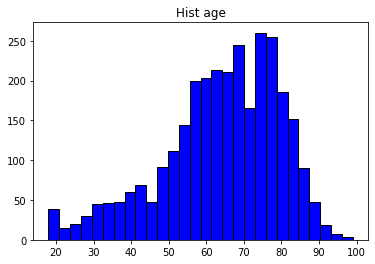

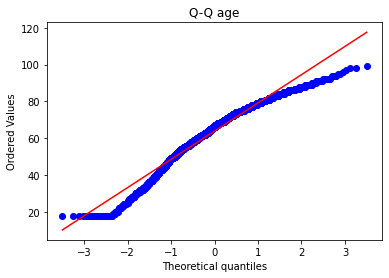

4.813976007345101e-28


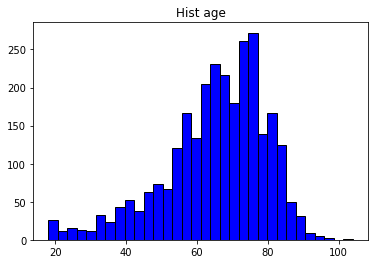

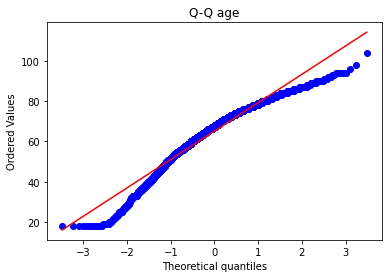

1.1558879025059394e-28


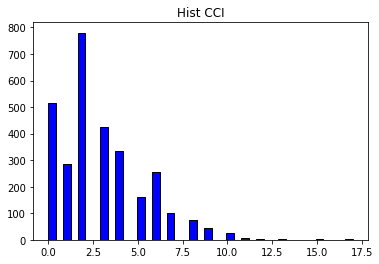

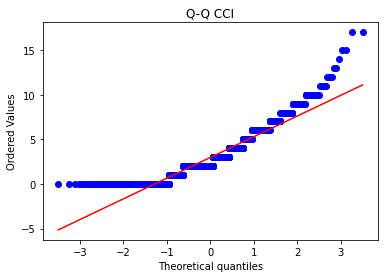

9.12512948282142e-40


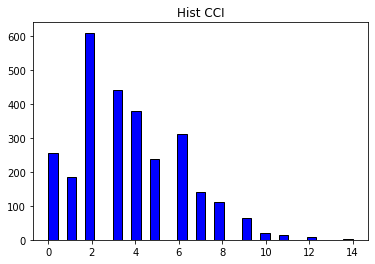

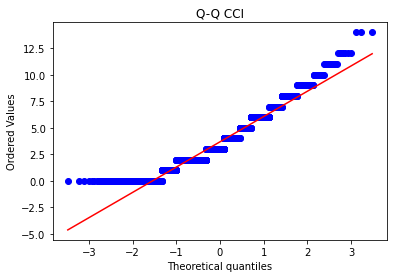

1.2023209186594654e-30


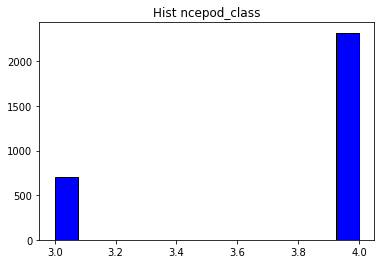

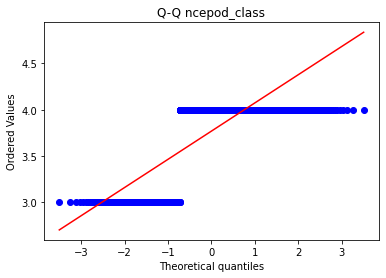

0.0


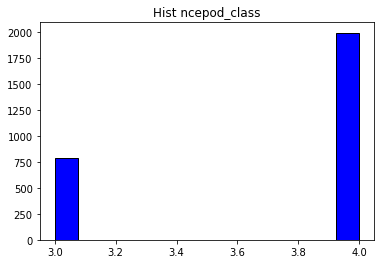

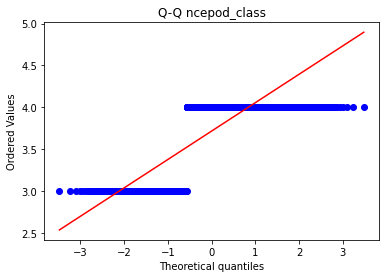

0.0


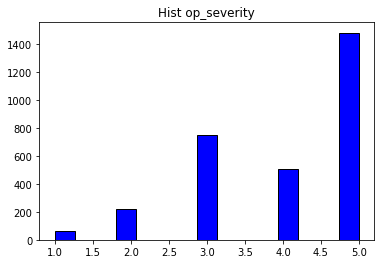

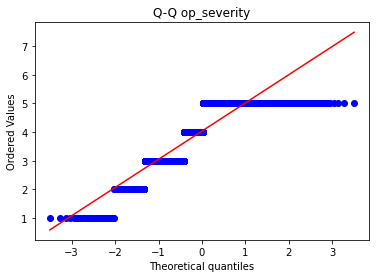

0.0


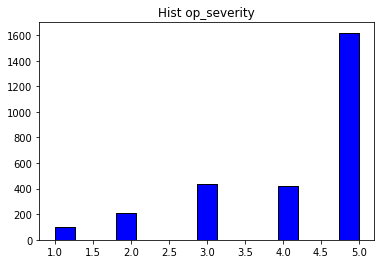

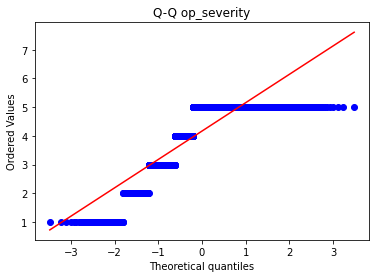

0.0


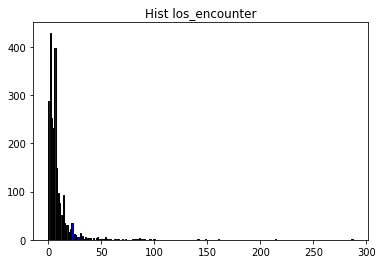

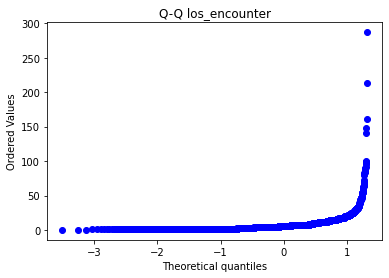

1.0


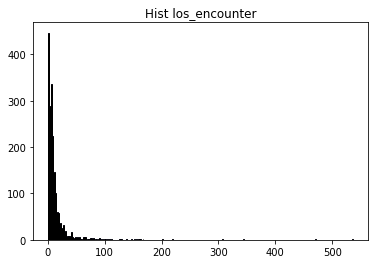

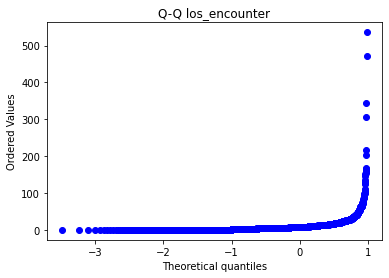

1.0


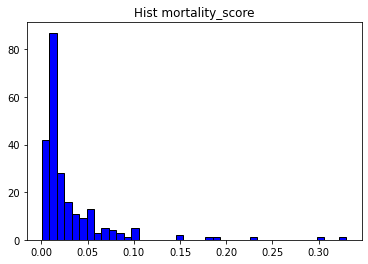

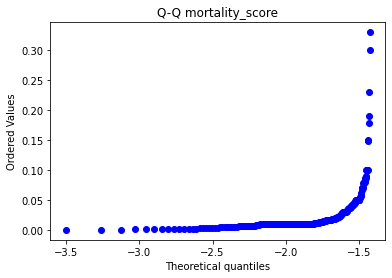

1.0


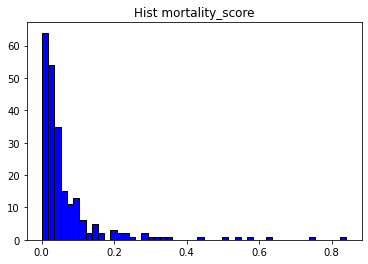

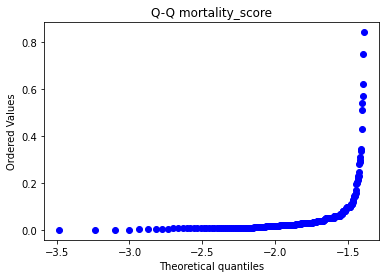

1.0


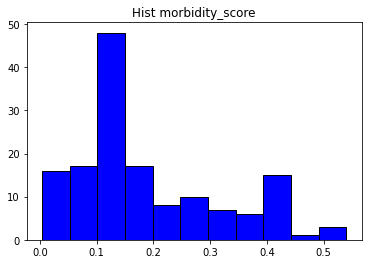

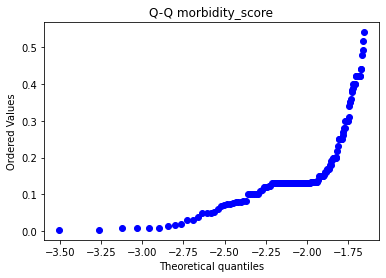

1.0


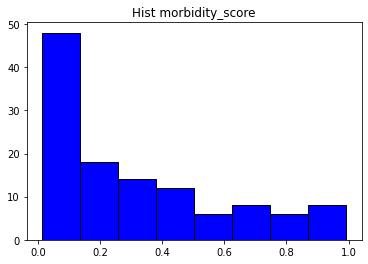

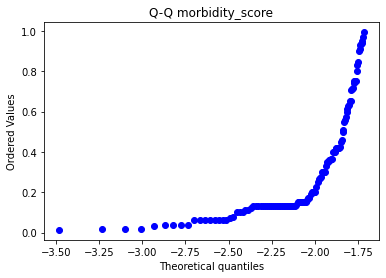

1.0


,n_whole,mean_whole,stdev_whole,median_whole,iqr_whole_low,iqr_whole_hi,count_ref_lvl1,mean_ref_lvl1,stdev_1,median_ref_lvl1,iqr_1_low,iqr_1_hi,count_ref_lvl23,mean_ref_lvl23,stdev_23,median_ref_lvl23,iqr_23_low,iqr_23_hi,p-value,test
age,0,64.49728764292017,15.058178939889423,67.0,56.0,76.0,0,63.879693208706925,15.624925986293137,66.0,55.0,76.0,0,65.16273362243365,14.390833263596322,67.0,57.0,76.0,0.006988096352910108,Wilcoxon Rank Sum
gender_female,2577,0.44385118842576643,0.49688010040858943,0.0,0.0,1.0,1387,0.45896757114493714,0.4983959635855433,0.0,0.0,1.0,1190,0.42759611929572405,0.49481881238987613,0.0,0.0,1.0,0.01745867613285131,Chi-Squared
white,4454,0.7671374440234241,0.4226918015007261,1.0,1.0,1.0,2257,0.7468563864990073,0.4348844754738775,1.0,0.0,1.0,2196,0.7890765361121093,0.4080374760322926,1.0,1.0,1.0,0.00016265753298977566,Chi-Squared
BAME,1351,0.23269032035825007,0.42258288224673674,0.0,0.0,0.0,765,0.25314361350099274,0.4348844754738775,0.0,0.0,1.0,586,0.21056413941789437,0.4077825811207896,0.0,0.0,0.0,0.00014223942382050894,Chi-Squared
asian,307,0.052876334826042024,0.22380584255285493,0.0,0.0,0.0,148,0.04897418927862343,0.21584979819599664,0.0,0.0,0.0,159,0.057132590729428674,0.2321375045499953,0.0,0.0,0.0,0.18390640467455693,Chi-Squared
black,172,0.029624526352049603,0.16956375168609944,0.0,0.0,0.0,98,0.03242885506287227,0.17716548984607408,0.0,0.0,0.0,74,0.0265900107797341,0.16091080087537188,0.0,0.0,0.0,0.21749634778389013,Chi-Squared
cardiac,1743,0.300206682741991,0.4583871947644054,0.0,0.0,1.0,834,0.2759761747187293,0.44707881537608857,0.0,0.0,1.0,909,0.3266259432267337,0.4690634234150018,0.0,0.0,1.0,2.9500502099070294e-05,Chi-Squared
kidney,789,0.13589390285911127,0.3427053816002975,0.0,0.0,0.0,385,0.12739907346128393,0.3334746589105684,0.0,0.0,0.0,404,0.14516708587854832,0.3523325261059736,0.0,0.0,0.0,0.052975493407532104,Chi-Squared
liver,377,0.06493282810885291,0.24642851965157753,0.0,0.0,0.0,166,0.05493050959629384,0.2278822783939759,0.0,0.0,0.0,211,0.07581746316924183,0.2647533985944695,0.0,0.0,0.0,0.0015093488283515982,Chi-Squared
neuro,655,0.11281433000344471,0.31639294952561214,0.0,0.0,0.0,313,0.10357379219060225,0.30475727289180593,0.0,0.0,0.0,342,0.12288896873877111,0.328368717490948,0.0,0.0,0.0,0.02247886661084061,Chi-Squared


In [30]:
comparisons = ['age', 'gender_female', 'white', 'BAME', 'asian', 'black', 'cardiac', 'kidney', 'liver', 'neuro', 'pulm', 'dementia', 'diabetes', 'comp_diabetes', 'htn', 'malignancy', 'metastasis', 'pvd', 'rheum', 'CCI', 'cancer_surgery', 'ncepod_class', 'op_severity', 'cancelled', 'cancel_nobed', 'los_encounter', 'died', 'died_6m', 'sop', 'cpet', 'clin_j', 'risk_score_patient', 'mortality_score', 'morbidity_score', 'over_8', '1-7_days', 'otd', 'ward_stepdowns', 'ward_stepdowns_nobed']

comparisons_data = []
for column in comparisons:
    data = comparison_analysis(title = column, data = [ref_lvl1[column], ref_lvl23[column], patient_dataset[column]])
    comparisons_data.append(data)
comparison_refs = pd.DataFrame(np.array(comparisons_data), columns = ['parameter', 'n_whole', 'mean_whole', 'stdev_whole', 'median_whole', 'iqr_whole_low', 'iqr_whole_hi', 'count_ref_lvl1', 'mean_ref_lvl1', 'stdev_1', 'median_ref_lvl1', 'iqr_1_low', 'iqr_1_hi', 'count_ref_lvl23', 'mean_ref_lvl23', 'stdev_23', 'median_ref_lvl23', 'iqr_23_low', 'iqr_23_hi', 'p-value', 'test']).set_index('parameter')
comparison_refs.index.name = None
comparison_refs.to_csv('comparison_refs.csv')
comparison_refs

## Old multivariate models

### LOS Multivariate Linear Model

In [31]:
covars_los = ['age',
#            'gender_male',
            'gender_female',
#            'gender_non_binary',
#            'asian',
#            'black',
#            'mixed',
#            'white',
#            'other',
            'cardiac',
#            'kidney',
#            'liver',
            'neuro',
            'pulm',
#            'dementia',
            'diabetes',
#            'comp_diabetes',
#            'htn',
            'malignancy',
#            'metastasis',
#            'pvd',
#            'rheum',
#            'surgical_speciality',
#            'proposed_procedure',
            'cancer_surgery',
            'ncepod_class',
            'op_severity',
#            'scheduled_start',
#            'previous_cancellation',
#            'kts',
#            'cancelled',
#            'critical_care_7_days',
#            'encounter_start',
#            'encounter_end',
#            'los_encounter',
#            'los_0',
#            'los_1',
#            'los_2',
#            'los_3',
#            'died',
#            'died_date',
#            'cancel_nobed',
#            'cancel_other',
#            'cancel_other_text',
#            'sop',
#            'cpet',
#            'clin_j',
#            'risk_score_patient',
#            'score_text',
#            'mortality_score',
#            'morbidity_score',
#            'other_reason',
#            'refer_other_text',
#            'over_8',
#            '1-7_days',
#            'otd',
#            'proposed_lvl',
#            'actual_lvl',
#            'difference_nobed',
#            'difference_other',
#            'difference_other_text',
#            'difference_unknown',
            'BAME',
#            'CCI',
#            'los_23',
#            'los_recount',
#            '1stepdowns',
#            '1stepdowns_nobed',
#            '23to0stepdowns',
#            '23to0stepdowns_nobed',
#            '23to1stepdowns',
#            '23to1stepdowns_nobed',
#            'ward_stepdowns',
#            'ward_stepdowns_nobed',
#            'died_6m',
#            'level0-1_crit_care',
#            'level0-1_crit_care_7d',
#            'hospital_name',
            'type',
#            'icb',
#            'level_1',
#            'num_level_1',
#            'level_2',
#            'level_3',
#            'em_dept',
#            'services',
            'n_services',
#            'lvl_1_emer_adm',
#            'mdt',
#            'risk_score',
#            'procedure_based',
#            'clinical_judgement',
#            'ref_anaes',
#            'ref_surg',
#            'ref_nurse',
#            'ref_spr',
#            'no_vetting',
#            'vet_anaes',
#            'vet_icu',
#            'vet_surg',
#            'vet_nurse',
#            'alo_anaes',
#            'alo_icu',
#            'alo_surg',
#            'alo_nurse',
#            'bed_nurse',
#            'nurse_bed_esc',
#            'cover_cons',
#            'cover_spr',
#            'cover_sho',
#            'clin_anaes',
#            'clin_icu',
#            'clin_surg',
#            'discharge_anaes',
#            'discharge_icu',
#            'discharge_surg',
#            'periph_vaso',
#            'central_vaso',
#            'cpap',
#            'bipap',
#            'stay_limit',
#            'all_spec',
#            'single_spec',
#            'level_1_ring',
#            'level_1_cap',
#            'level_1_esc',
#            'level_2_ring',
#            'level_2_cap',
#            'level_2_esc',
#            'level_3_ring',
#            'level_3_cap',
#            'level_3_esc',
#            'level_23_ring',
#            'level_23_cap',
#            'level_23_esc',
#            'totalringcap',
#            'total_op',
#            '%day',
#            'surg_adm',
#            '%emerg',
#            'cancel_per_1000_total',
#            'cancel_nobed_per_1000',
#            'c_ref_lvl1',
#            'c_plan_adm_lvl1',
#            'c_adm_lvl1',
#            'ref_lvl1_per_1000',
#            'plan_adm_lvl1_per_1000',
#            'adm_lvl1_per_1000',
#            '%emerg_lvl1',
#            'c_ref_lvl23',
#            'c_plan_adm_lvl23',
#            'c_adm_lvl23',
#            'ref_lvl23_per_1000',
#            'plan_adm_lvl23_per_1000',
#            'adm_lvl23_per_1000',
#            '%emerg_lvl23',
#            'EhC_refs',
#            'avg_age',
#            '%female',
#            '%white',
#            '%BAME',
#            '%asian',
#            '%black',
#            '%cardiac',
#            '%kidney',
#            '%liver',
#            '%neuro',
#            '%pulm',
#            '%dementia',
#            '%diabetes',
#            '%comp_diabetes',
#            '%htn',
#            '%malignancy',
#            '%metastasis',
#            '%pvd',
#            '%rheum',
#            'avg_CCI',
#            '%cancer_surgery',
#            'avg_ncepod',
#            'avg_severity',
#            '%cancelled',
#            '%cancelled_nobed',
#            '%level0-1_crit_care',
#            '%level0-1_crit_care_7d',
#            'LOS_mean',
#            'LOS_median',
#            'LOS1_mean',
#            'LOS1_median',
#            'LOS23_mean',
#            'LOS23_median',
#            '%died',
#            '%died_6m',
#            '%clin_j',
#            '%cpet',
#            '%sop',
#            '%risk_score',
#            'pred_mortality',
#            'pred_morbidity',
#            '%ref_over8',
#            '%ref_1_7',
#            '%ref_otd',
#            '%_1_ref_over8',
#            '%_1_ref_1_7',
#            '%_1_ref_otd',
#            '%_23_ref_over8',
#            '%_23_ref_1_7',
#            '%_23_ref_otd',
#            '%1stepdowns',
#            '%1stepdowns_nobed',
#            '%23to0stepdowns',
#            '%23to0stepdowns_nobed',
#            '%23to1stepdowns',
#            '%23to1stepdowns_nobed',
#            '%ward_stepdowns',
#            '%ward_stepdowns_nobed',
#            'ref_to_cap_1',
#            'ref_to_cap_23',
            'enhanced_care_ref',
#            'enhanced_care_adm'
                               ]


 GRAPHS OF UNIVARIATE ASSOCIATIONS ----



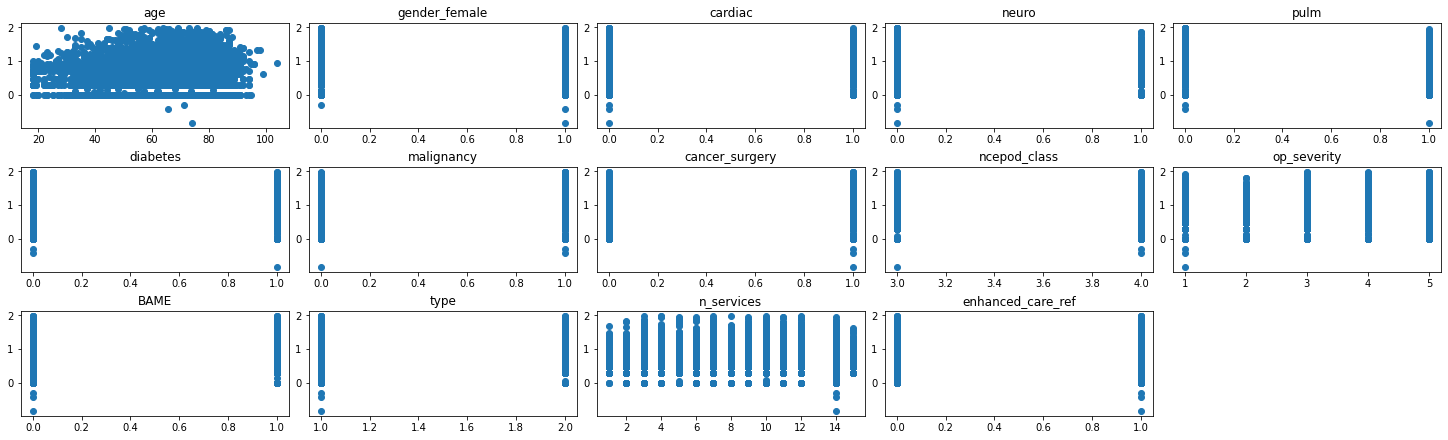


 ASSESSMENT OF UNIVARIATE ASSOCIATIONS ----

                            OLS Regression Results                            
Dep. Variable:          los_encounter   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     50.97
Date:                Fri, 21 Mar 2025   Prob (F-statistic):           1.07e-12
Time:                        11:09:26   Log-Likelihood:                -2894.0
No. Observations:                4966   AIC:                             5792.
Df Residuals:                    4964   BIC:                             5805.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

C:\Users\chris\AppData\Local\Temp\ipykernel_19540\3526545750.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(resids, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = stats.norm)
C:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


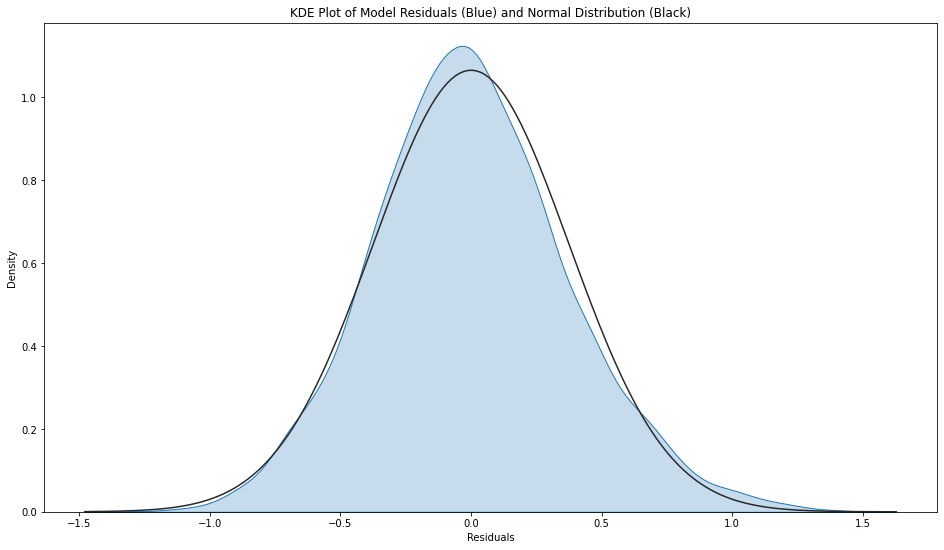

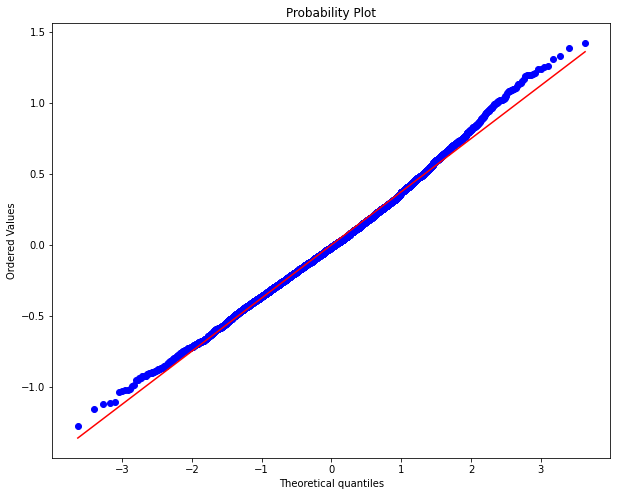

ShapiroResult(statistic=0.9956989288330078, pvalue=6.551476722238547e-11)

 ASSESSMENT OF MULTICOLLINEARITY ----


 Variance Inflation Factor ----
age: 1.1371330466117533
gender_female: 1.0265640319608378
cardiac: 1.144935464951257
neuro: 1.0342236129208344
pulm: 1.0375845557153642
diabetes: 1.0317870873099821
malignancy: 2.035666961648851
cancer_surgery: 2.050820553272055
ncepod_class: 1.0461818717342122
op_severity: 1.1163354755928354
BAME: 1.0359778845189778
type: 1.627239622276867
n_services: 1.5802808554649148
enhanced_care_ref: 1.0399056050266156


C:\Users\chris\AppData\Local\Temp\ipykernel_19540\3079330447.py:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data[[item for item in indep_var.columns[1:]]].corr(),vmin=-1,annot= True)


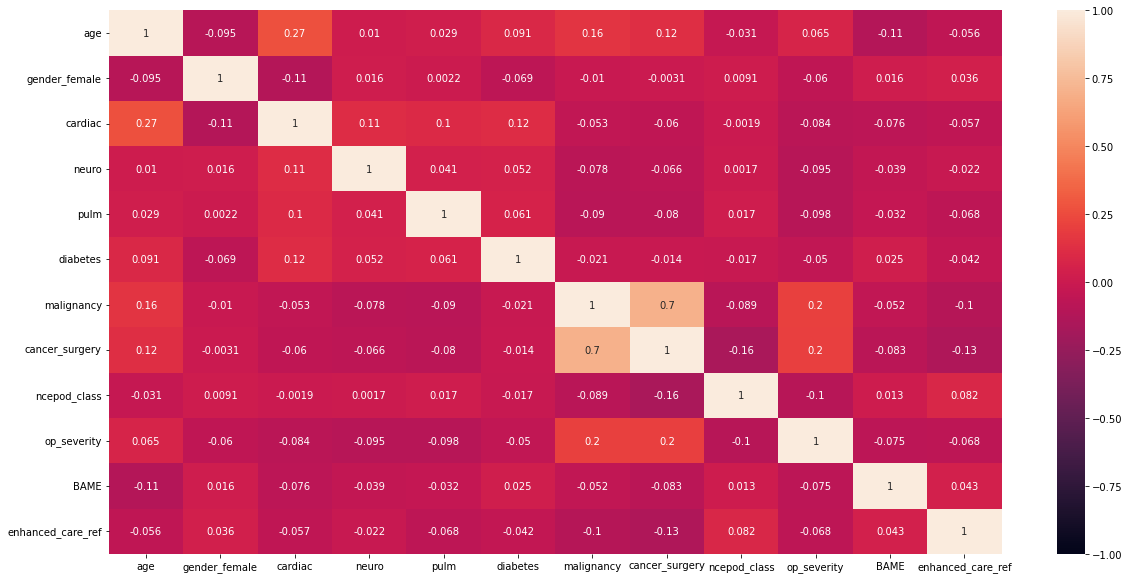


 ASSESSMENT OF HOMOSCEDASICITY ----


 White test ----
                                      value
Lagrange multiplier statistic  3.627672e+02
p-value                        2.815778e-29
f-value                        3.544128e+00
f p-value                      8.986013e-31

 Breusch-Pagan test ----
                                      value
Lagrange multiplier statistic  1.587146e+02
p-value                        1.286524e-26
f-value                        1.167567e+01
f p-value                      4.438458e-27

 Goldfeld-Quandt test ----
                value
F statistic  1.003030
p-value      0.470054

 Residuals plots ----


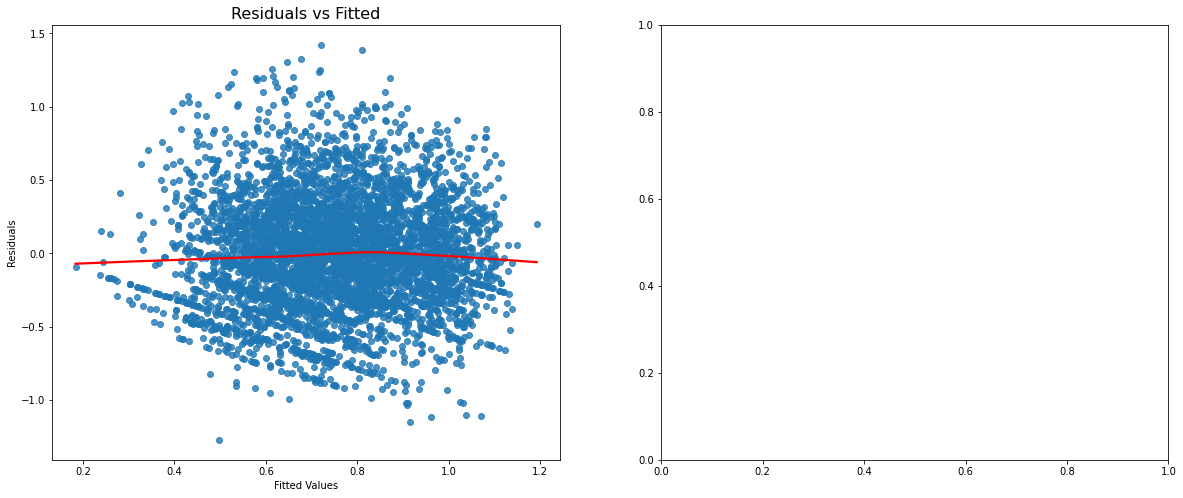


 ASSESSMENT OF INDEPENDENCE OF VARIABLES FROM THE ERROR TERM ----



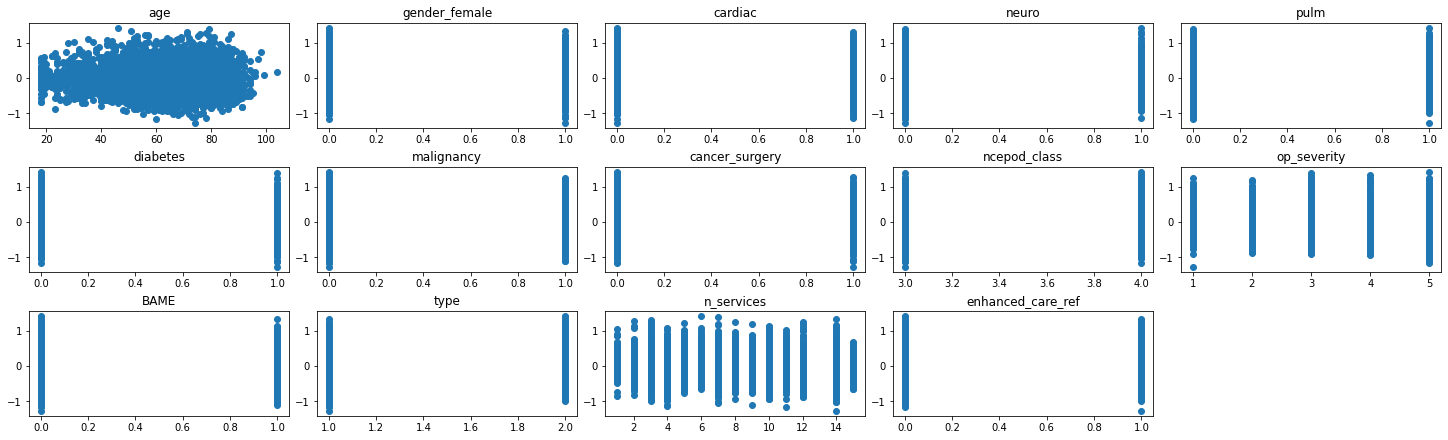


 ASSESSMENT OF INDEPENDENCE OF ERROR TERM VALUES ----



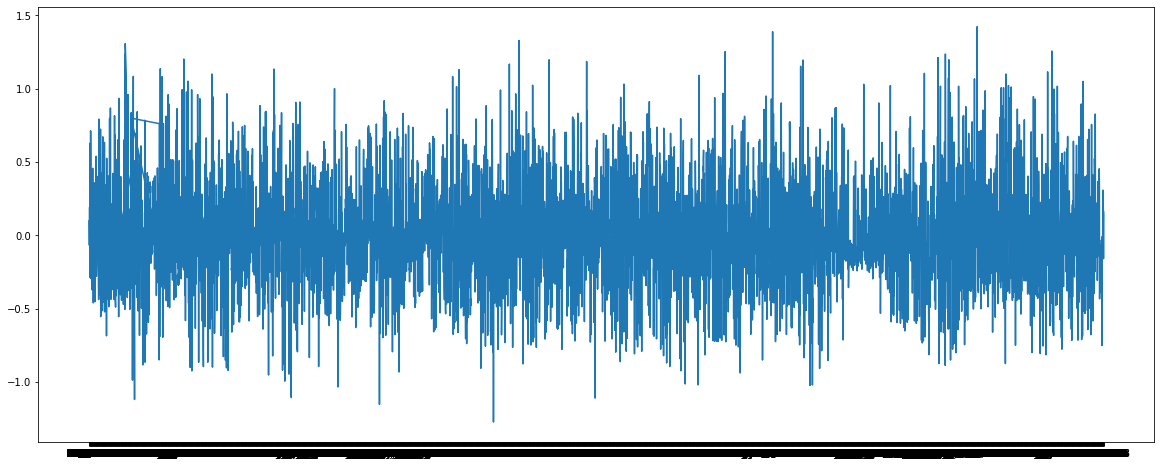


 REGRESSION RESULTS ----
            Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: los_encounter
No. Observations:   4966    Method:             REML         
No. Groups:         59      Scale:              0.1421       
Min. group size:    1       Log-Likelihood:     -2318.4359   
Max. group size:    507     Converged:          Yes          
Mean group size:    84.2                                     
-------------------------------------------------------------
                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------
const              0.614    0.152   4.049 0.000  0.317  0.911
age                0.002    0.000   5.011 0.000  0.001  0.003
gender_female      0.007    0.011   0.674 0.500 -0.014  0.029
cardiac           -0.002    0.013  -0.153 0.879 -0.027  0.023
neuro             -0.017    0.019  -0.898 0.369 -0.053  0.020
pulm              -0.050    0.013  -3.865 0.000 -0.075 -

In [32]:
regress_assess(patient_nocancellations, 
               'los_encounter', 
               covars_los, 
               outlier_title='los_encounter', 
               outlier_low=0, 
               outlier_high=100, 
               group='hospital_name', 
               multi=True, log=True, 
               wls=False)

### Multivariate Logistic Models

#### Cancellation due to a lack of bed

In [33]:
covars_cancel_nobed = ['age',
#            'gender_male',
#            'gender_female',
#            'gender_non_binary',
#            'asian',
#            'black',
#            'mixed',
#            'white',
#            'other',
            'cardiac',
#            'kidney',
#            'liver',
            'neuro',
            'pulm',
#            'dementia',
#            'diabetes',
#            'comp_diabetes',
#            'htn',
#            'malignancy',
#            'metastasis',
#            'pvd',
#            'rheum',
#            'surgical_speciality',
#            'proposed_procedure',
            'cancer_surgery',
#            'ncepod_class',
            'op_severity',
#            'scheduled_start',
#            'previous_cancellation',
#            'kts',
#            'cancelled',
#            'critical_care_7_days',
#            'encounter_start',
#            'encounter_end',
#            'los_encounter',
#            'los_0',
#            'los_1',
#            'los_2',
#            'los_3',
#            'died',
#            'died_date',
#            'cancel_nobed',
#            'cancel_other',
#            'cancel_other_text',
            'sop',
#            'cpet',
            'clin_j',
#            'risk_score_patient',
#            'score_text',
#            'mortality_score',
#            'morbidity_score',
#            'other_reason',
#            'refer_other_text',
#            'over_8',
#            '1-7_days',
#            'otd',
#            'proposed_lvl',
#            'actual_lvl',
#            'difference_nobed',
#            'difference_other',
#            'difference_other_text',
#            'difference_unknown',
#            'BAME',
#            'CCI',
#            'los_23',
#            'los_recount',
#            '1stepdowns',
#            '1stepdowns_nobed',
#            '23to0stepdowns',
#            '23to0stepdowns_nobed',
#            '23to1stepdowns',
#            '23to1stepdowns_nobed',
#            'ward_stepdowns',
#            'ward_stepdowns_nobed',
#            'died_6m',
#            'level0-1_crit_care',
#            'level0-1_crit_care_7d',
#            'hospital_name',
#            'type',
#            'icb',
#            'level_1',
#            'num_level_1',
#            'level_2',
#            'level_3',
#            'em_dept',
#            'services',
#            'n_services',
#            'lvl_1_emer_adm',
#            'mdt',
#            'risk_score',
#            'procedure_based',
#            'clinical_judgement',
#            'ref_anaes',
#            'ref_surg',
#            'ref_nurse',
#            'ref_spr',
#            'no_vetting',
#            'vet_anaes',
#            'vet_icu',
#            'vet_surg',
#            'vet_nurse',
#            'alo_anaes',
#            'alo_icu',
#            'alo_surg',
#            'alo_nurse',
#            'bed_nurse',
#            'nurse_bed_esc',
#            'cover_cons',
#            'cover_spr',
#            'cover_sho',
#            'clin_anaes',
#            'clin_icu',
#            'clin_surg',
#            'discharge_anaes',
#            'discharge_icu',
#            'discharge_surg',
#            'periph_vaso',
#            'central_vaso',
#            'cpap',
#            'bipap',
#            'stay_limit',
#            'all_spec',
#            'single_spec',
#            'level_1_ring',
            'level_1_cap',
#            'level_1_esc',
#            'level_2_ring',
#            'level_2_cap',
#            'level_2_esc',
#            'level_3_ring',
#            'level_3_cap',
#            'level_3_esc',
#            'level_23_ring',
            'level_23_cap',
#            'level_23_esc',
#            'totalringcap',
#            'total_op',
#            '%day',
#            'surg_adm',
#            '%emerg',
#            'cancel_per_1000_total',
#            'cancel_nobed_per_1000',
#            'c_ref_lvl1',
#            'c_plan_adm_lvl1',
#            'c_adm_lvl1',
#            'ref_lvl1_per_1000',
#            'plan_adm_lvl1_per_1000',
#            'adm_lvl1_per_1000',
#            '%emerg_lvl1',
#            'c_ref_lvl23',
#            'c_plan_adm_lvl23',
#            'c_adm_lvl23',
#            'ref_lvl23_per_1000',
#            'plan_adm_lvl23_per_1000',
            'adm_lvl23_per_1000',
#            '%emerg_lvl23',
#            'EhC_refs',
#            'avg_age',
#            '%female',
#            '%white',
#            '%BAME',
#            '%asian',
#            '%black',
#            '%cardiac',
#            '%kidney',
#            '%liver',
#            '%neuro',
#            '%pulm',
#            '%dementia',
#            '%diabetes',
#            '%comp_diabetes',
#            '%htn',
#            '%malignancy',
#            '%metastasis',
#            '%pvd',
#            '%rheum',
#            'avg_CCI',
#            '%cancer_surgery',
#            'avg_ncepod',
#            'avg_severity',
#            '%cancelled',
#            '%cancelled_nobed',
#            '%level0-1_crit_care',
#            '%level0-1_crit_care_7d',
#            'LOS_mean',
#            'LOS_median',
#            'LOS1_mean',
#            'LOS1_median',
#            'LOS23_mean',
#            'LOS23_median',
#            '%died',
#            '%died_6m',
#            '%clin_j',
#            '%cpet',
#            '%sop',
#            '%risk_score',
#            'pred_mortality',
#            'pred_morbidity',
#            '%ref_over8',
#            '%ref_1_7',
            '%ref_otd',
#            '%_1_ref_over8',
#            '%_1_ref_1_7',
#            '%_1_ref_otd',
#            '%_23_ref_over8',
#            '%_23_ref_1_7',
#            '%_23_ref_otd',
#            '%1stepdowns',
#            '%1stepdowns_nobed',
#            '%23to0stepdowns',
#            '%23to0stepdowns_nobed',
#            '%23to1stepdowns',
#            '%23to1stepdowns_nobed',
            '%ward_stepdowns',
#            '%ward_stepdowns_nobed',
#            'ref_to_cap_1',
#            'ref_to_cap_23',
            'enhanced_care_ref',
#            'enhanced_care_adm'
                               ]

Optimization terminated successfully.
         Current function value: 0.142281
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           cancel_nobed   No. Observations:                 5806
Model:                          Logit   Df Residuals:                     5804
Method:                           MLE   Df Model:                            1
Date:                Fri, 21 Mar 2025   Pseudo R-squ.:               0.0003862
Time:                        11:09:56   Log-Likelihood:                -826.08
converged:                       True   LL-Null:                       -826.40
Covariance Type:            nonrobust   LLR p-value:                    0.4243
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1536      0.317     -9.964      0.000      -3.774      -2.533
age           -0.0039      0.

C:\Users\chris\AppData\Local\Temp\ipykernel_19540\3079330447.py:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data[[item for item in indep_var.columns[1:]]].corr(),vmin=-1,annot= True)


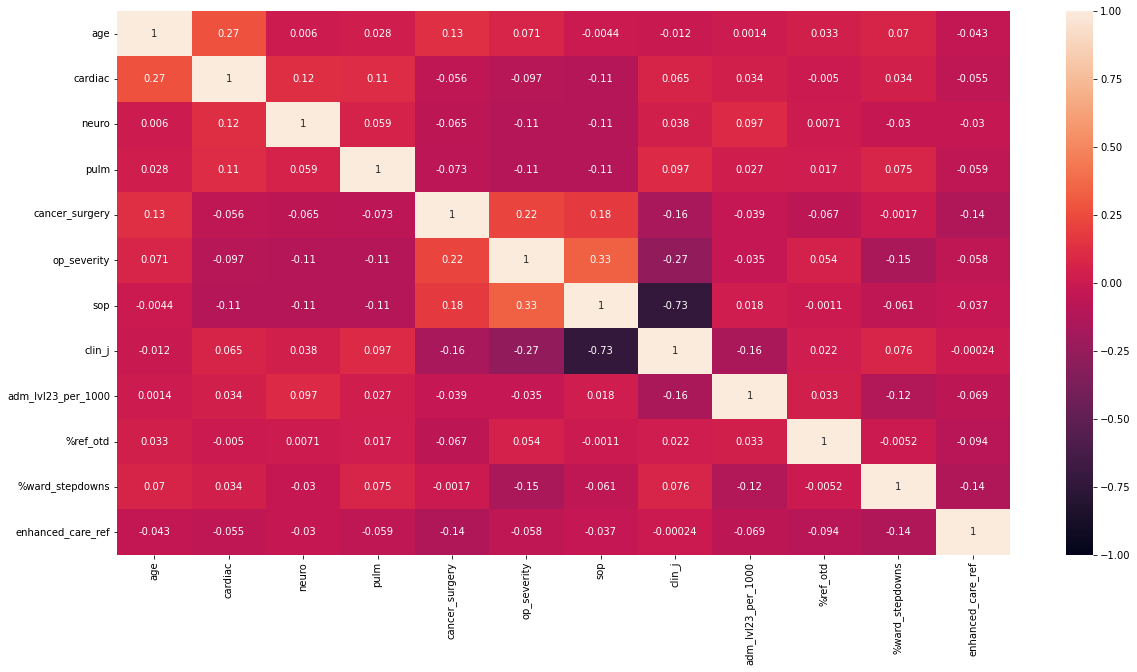

                           Logit Regression Results                           
Dep. Variable:           cancel_nobed   No. Observations:                 5806
Model:                          Logit   Df Residuals:                     5791
Method:                           MLE   Df Model:                           14
Date:                Fri, 21 Mar 2025   Pseudo R-squ.:                 0.07524
Time:                        11:09:57   Log-Likelihood:                -764.22
converged:                       True   LL-Null:                       -826.40
Covariance Type:            nonrobust   LLR p-value:                 8.787e-20
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.6333      0.522     -3.129      0.002      -2.656      -0.610
age                   -0.0056      0.005     -1.056      0.291      -0.016       0.005
cardiac             

In [34]:
dep_var = patient_dataset['cancel_nobed']
dep_var = dep_var.fillna(0)
indep_var = patient_dataset[covars_cancel_nobed].fillna(0)

for variable in covars_cancel_nobed:
    temp_indep = sm.tools.tools.add_constant(patient_dataset[variable])
    temp_indep = temp_indep.fillna(0)
    temp_model = sm.discrete.discrete_model.Logit(dep_var, temp_indep).fit()
    print(temp_model.summary())

indep_var = sm.tools.tools.add_constant(indep_var)
model = sm.discrete.discrete_model.Logit(dep_var, indep_var).fit()

multicol(patient_dataset, indep_var)
print(model.summary())
print('AIC: '+str(model.aic))

#### Cancellation

In [35]:
covars_cancelled = ['age',
#            'gender_male',
#            'gender_female',
#            'gender_non_binary',
#            'asian',
#            'black',
#            'mixed',
#            'white',
#            'other',
            'cardiac',
#            'kidney',
#            'liver',
            'neuro',
            'pulm',
#            'dementia',
#            'diabetes',
#            'comp_diabetes',
#            'htn',
#            'malignancy',
#            'metastasis',
#            'pvd',
#            'rheum',
#            'surgical_speciality',
#            'proposed_procedure',
            'cancer_surgery',
#            'ncepod_class',
            'op_severity',
#            'scheduled_start',
#            'previous_cancellation',
#            'kts',
#            'cancelled',
#            'critical_care_7_days',
#            'encounter_start',
#            'encounter_end',
#            'los_encounter',
#            'los_0',
#            'los_1',
#            'los_2',
#            'los_3',
#            'died',
#            'died_date',
#            'cancel_nobed',
#            'cancel_other',
#            'cancel_other_text',
            'sop',
#            'cpet',
            'clin_j',
#            'risk_score_patient',
#            'score_text',
#            'mortality_score',
#            'morbidity_score',
#            'other_reason',
#            'refer_other_text',
#            'over_8',
#            '1-7_days',
            'otd',
#            'proposed_lvl',
#            'actual_lvl',
#            'difference_nobed',
#            'difference_other',
#            'difference_other_text',
#            'difference_unknown',
#            'BAME',
#            'CCI',
#            'los_23',
#            'los_recount',
#            '1stepdowns',
#            '1stepdowns_nobed',
#            '23to0stepdowns',
#            '23to0stepdowns_nobed',
#            '23to1stepdowns',
#            '23to1stepdowns_nobed',
#            'ward_stepdowns',
#            'ward_stepdowns_nobed',
#            'died_6m',
#            'level0-1_crit_care',
#            'level0-1_crit_care_7d',
#            'hospital_name',
#            'type',
#            'icb',
#            'level_1',
#            'num_level_1',
#            'level_2',
#            'level_3',
            'em_dept',
#            'services',
            'n_services',
#            'lvl_1_emer_adm',
#            'mdt',
#            'risk_score',
#            'procedure_based',
#            'clinical_judgement',
#            'ref_anaes',
#            'ref_surg',
#            'ref_nurse',
#            'ref_spr',
#            'no_vetting',
#            'vet_anaes',
#            'vet_icu',
#            'vet_surg',
#            'vet_nurse',
#            'alo_anaes',
#            'alo_icu',
#            'alo_surg',
#            'alo_nurse',
#            'bed_nurse',
#            'nurse_bed_esc',
#            'cover_cons',
#            'cover_spr',
#            'cover_sho',
#            'clin_anaes',
#            'clin_icu',
#            'clin_surg',
#            'discharge_anaes',
#            'discharge_icu',
#            'discharge_surg',
#            'periph_vaso',
#            'central_vaso',
#            'cpap',
#            'bipap',
#            'stay_limit',
#            'all_spec',
#            'single_spec',
#            'level_1_ring',
            'level_1_cap',
#            'level_1_esc',
#            'level_2_ring',
#            'level_2_cap',
#            'level_2_esc',
#            'level_3_ring',
#            'level_3_cap',
#            'level_3_esc',
#            'level_23_ring',
#            'level_23_cap',
#            'level_23_esc',
#            'totalringcap',
#            'total_op',
#            '%day',
#            'surg_adm',
#            '%emerg',
#            'cancel_per_1000_total',
#            'cancel_nobed_per_1000',
#            'c_ref_lvl1',
#            'c_plan_adm_lvl1',
#            'c_adm_lvl1',
#            'ref_lvl1_per_1000',
#            'plan_adm_lvl1_per_1000',
#            'adm_lvl1_per_1000',
#            '%emerg_lvl1',
#            'c_ref_lvl23',
#            'c_plan_adm_lvl23',
#            'c_adm_lvl23',
#            'ref_lvl23_per_1000',
#            'plan_adm_lvl23_per_1000',
            'adm_lvl23_per_1000',
#            '%emerg_lvl23',
            'EhC_refs',
#            'avg_age',
#            '%female',
#            '%white',
#            '%BAME',
#            '%asian',
#            '%black',
#            '%cardiac',
#            '%kidney',
#            '%liver',
#            '%neuro',
#            '%pulm',
#            '%dementia',
#            '%diabetes',
#            '%comp_diabetes',
#            '%htn',
#            '%malignancy',
#            '%metastasis',
#            '%pvd',
#            '%rheum',
#            'avg_CCI',
#            '%cancer_surgery',
#            'avg_ncepod',
#            'avg_severity',
#            '%cancelled',
#            '%cancelled_nobed',
#            '%level0-1_crit_care',
#            '%level0-1_crit_care_7d',
#            'LOS_mean',
#            'LOS_median',
#            'LOS1_mean',
#            'LOS1_median',
#            'LOS23_mean',
#            'LOS23_median',
#            '%died',
#            '%died_6m',
#            '%clin_j',
#            '%cpet',
#            '%sop',
#            '%risk_score',
#            'pred_mortality',
#            'pred_morbidity',
#            '%ref_over8',
#            '%ref_1_7',
#            '%ref_otd',
#            '%_1_ref_over8',
#            '%_1_ref_1_7',
#            '%_1_ref_otd',
#            '%_23_ref_over8',
#            '%_23_ref_1_7',
#            '%_23_ref_otd',
#            '%1stepdowns',
#            '%1stepdowns_nobed',
#            '%23to0stepdowns',
#            '%23to0stepdowns_nobed',
#            '%23to1stepdowns',
#            '%23to1stepdowns_nobed',
#            '%ward_stepdowns',
#            '%ward_stepdowns_nobed',
#            'ref_to_cap_1',
#            'ref_to_cap_23',
            'enhanced_care_ref',
#            'enhanced_care_adm'
                               ]

Optimization terminated successfully.
         Current function value: 0.299076
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              cancelled   No. Observations:                 5806
Model:                          Logit   Df Residuals:                     5804
Method:                           MLE   Df Model:                            1
Date:                Fri, 21 Mar 2025   Pseudo R-squ.:               0.0001528
Time:                        11:09:57   Log-Likelihood:                -1736.4
converged:                       True   LL-Null:                       -1736.7
Covariance Type:            nonrobust   LLR p-value:                    0.4663
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1890      0.200    -10.948      0.000      -2.581      -1.797
age           -0.0022      0.

C:\Users\chris\AppData\Local\Temp\ipykernel_19540\3079330447.py:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data[[item for item in indep_var.columns[1:]]].corr(),vmin=-1,annot= True)


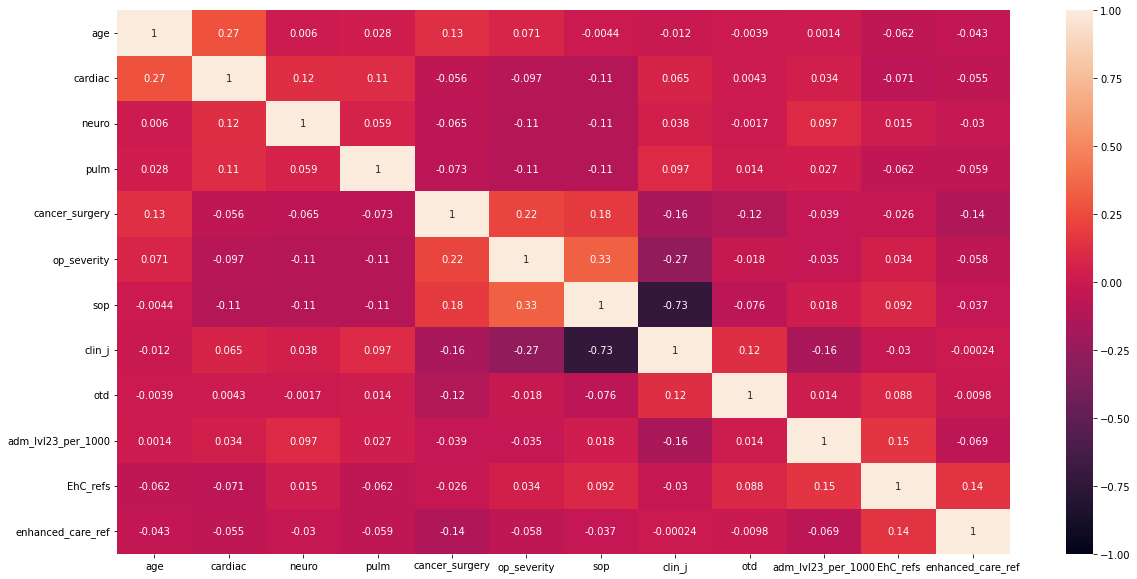

                           Logit Regression Results                           
Dep. Variable:              cancelled   No. Observations:                 5806
Model:                          Logit   Df Residuals:                     5790
Method:                           MLE   Df Model:                           15
Date:                Fri, 21 Mar 2025   Pseudo R-squ.:                 0.04277
Time:                        11:09:58   Log-Likelihood:                -1662.4
converged:                       True   LL-Null:                       -1736.7
Covariance Type:            nonrobust   LLR p-value:                 4.677e-24
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.6533      0.335     -4.941      0.000      -2.309      -0.997
age                   -0.0039      0.003     -1.192      0.233      -0.010       0.002
cardiac             

In [36]:
dep_var = patient_dataset['cancelled']
dep_var = dep_var.fillna(0)
indep_var = patient_dataset[covars_cancelled].fillna(0)

for variable in covars_cancelled:
    temp_indep = sm.tools.tools.add_constant(patient_dataset[variable])
    temp_indep = temp_indep.fillna(0)
    temp_model = sm.discrete.discrete_model.Logit(dep_var, temp_indep).fit()
    print(temp_model.summary())

indep_var = sm.tools.tools.add_constant(indep_var)
model = sm.discrete.discrete_model.Logit(dep_var, indep_var).fit()
multicol(patient_dataset, indep_var)
print(model.summary())
print('AIC: '+str(model.aic))

#### Mortality within 6 months

In [37]:
covars_died_6m = ['age',
#            'gender_male',
#            'gender_female',
#            'gender_non_binary',
#            'asian',
#            'black',
#            'mixed',
#            'white',
#            'other',
            'cardiac',
            'kidney',
#            'liver',
            'neuro',
            'pulm',
            'dementia',
#            'diabetes',
#            'comp_diabetes',
#            'htn',
#            'malignancy',
#            'metastasis',
#            'pvd',
#            'rheum',
#            'surgical_speciality',
#            'proposed_procedure',
            'cancer_surgery',
            'ncepod_class',
            'op_severity',
#            'scheduled_start',
#            'previous_cancellation',
#            'kts',
#            'cancelled',
#            'critical_care_7_days',
#            'encounter_start',
#            'encounter_end',
#            'los_encounter',
#            'los_0',
#            'los_1',
#            'los_2',
#            'los_3',
#            'died',
#            'died_date',
#            'cancel_nobed',
#            'cancel_other',
#            'cancel_other_text',
#            'sop',
#            'cpet',
#            'clin_j',
#            'risk_score_patient',
#            'score_text',
#            'mortality_score',
#            'morbidity_score',
#            'other_reason',
#            'refer_other_text',
            'over_8',
#            '1-7_days',
            'otd',
#            'proposed_lvl',
            'actual_lvl',
#            'difference_nobed',
#            'difference_other',
#            'difference_other_text',
#            'difference_unknown',
#            'BAME',
            'CCI',
#            'los_23',
#            'los_recount',
#            '1stepdowns',
#            '1stepdowns_nobed',
#            '23to0stepdowns',
#            '23to0stepdowns_nobed',
#            '23to1stepdowns',
#            '23to1stepdowns_nobed',
#            'ward_stepdowns',
#            'ward_stepdowns_nobed',
#            'died_6m',
#            'level0-1_crit_care',
#            'level0-1_crit_care_7d',
#            'hospital_name',
            'type',
#            'icb',
#            'level_1',
#            'num_level_1',
#            'level_2',
#            'level_3',
#            'em_dept',
#            'services',
#            'n_services',
#            'lvl_1_emer_adm',
#            'mdt',
#            'risk_score',
#            'procedure_based',
#            'clinical_judgement',
#            'ref_anaes',
#            'ref_surg',
#            'ref_nurse',
#            'ref_spr',
#            'no_vetting',
#            'vet_anaes',
#            'vet_icu',
#            'vet_surg',
#            'vet_nurse',
#            'alo_anaes',
#            'alo_icu',
#            'alo_surg',
#            'alo_nurse',
#            'bed_nurse',
#            'nurse_bed_esc',
#            'cover_cons',
#            'cover_spr',
#            'cover_sho',
#            'clin_anaes',
#            'clin_icu',
#            'clin_surg',
#            'discharge_anaes',
#            'discharge_icu',
#            'discharge_surg',
#            'periph_vaso',
#            'central_vaso',
#            'cpap',
#            'bipap',
#            'stay_limit',
#            'all_spec',
#            'single_spec',
#            'level_1_ring',
#            'level_1_cap',
#            'level_1_esc',
#            'level_2_ring',
#            'level_2_cap',
#            'level_2_esc',
#            'level_3_ring',
#            'level_3_cap',
#            'level_3_esc',
#            'level_23_ring',
#            'level_23_cap',
#            'level_23_esc',
#            'totalringcap',
            'total_op',
#            '%day',
#            'surg_adm',
#            '%emerg',
#            'cancel_per_1000_total',
#            'cancel_nobed_per_1000',
#            'c_ref_lvl1',
#            'c_plan_adm_lvl1',
#            'c_adm_lvl1',
#            'ref_lvl1_per_1000',
#            'plan_adm_lvl1_per_1000',
#            'adm_lvl1_per_1000',
#            '%emerg_lvl1',
#            'c_ref_lvl23',
#            'c_plan_adm_lvl23',
#            'c_adm_lvl23',
#            'ref_lvl23_per_1000',
#            'plan_adm_lvl23_per_1000',
#            'adm_lvl23_per_1000',
#            '%emerg_lvl23',
#            'EhC_refs',
#            'avg_age',
#            '%female',
#            '%white',
#            '%BAME',
#            '%asian',
#            '%black',
#            '%cardiac',
#            '%kidney',
#            '%liver',
#            '%neuro',
#            '%pulm',
#            '%dementia',
#            '%diabetes',
#            '%comp_diabetes',
#            '%htn',
#            '%malignancy',
#            '%metastasis',
#            '%pvd',
#            '%rheum',
#            'avg_CCI',
#            '%cancer_surgery',
#            'avg_ncepod',
#            'avg_severity',
#            '%cancelled',
#            '%cancelled_nobed',
#            '%level0-1_crit_care',
#            '%level0-1_crit_care_7d',
#            'LOS_mean',
#            'LOS_median',
#            'LOS1_mean',
#            'LOS1_median',
#            'LOS23_mean',
#            'LOS23_median',
#            '%died',
#            '%died_6m',
#            '%clin_j',
#            '%cpet',
#            '%sop',
#            '%risk_score',
#            'pred_mortality',
#            'pred_morbidity',
#            '%ref_over8',
#            '%ref_1_7',
#            '%ref_otd',
#            '%_1_ref_over8',
#            '%_1_ref_1_7',
#            '%_1_ref_otd',
#            '%_23_ref_over8',
#            '%_23_ref_1_7',
#            '%_23_ref_otd',
#            '%1stepdowns',
#            '%1stepdowns_nobed',
#            '%23to0stepdowns',
#            '%23to0stepdowns_nobed',
#            '%23to1stepdowns',
#            '%23to1stepdowns_nobed',
            '%ward_stepdowns',
#            '%ward_stepdowns_nobed',
#            'ref_to_cap_1',
#            'ref_to_cap_23',
            'enhanced_care_ref',
#            'enhanced_care_adm'
                               ]

Optimization terminated successfully.
         Current function value: 0.125952
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                died_6m   No. Observations:                 5292
Model:                          Logit   Df Residuals:                     5290
Method:                           MLE   Df Model:                            1
Date:                Fri, 21 Mar 2025   Pseudo R-squ.:                 0.01293
Time:                        11:09:58   Log-Likelihood:                -666.54
converged:                       True   LL-Null:                       -675.27
Covariance Type:            nonrobust   LLR p-value:                 2.928e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.2688      0.456    -11.564      0.000      -6.162      -4.376
age            0.0257      0.

C:\Users\chris\AppData\Local\Temp\ipykernel_19540\3079330447.py:16: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data[[item for item in indep_var.columns[1:]]].corr(),vmin=-1,annot= True)


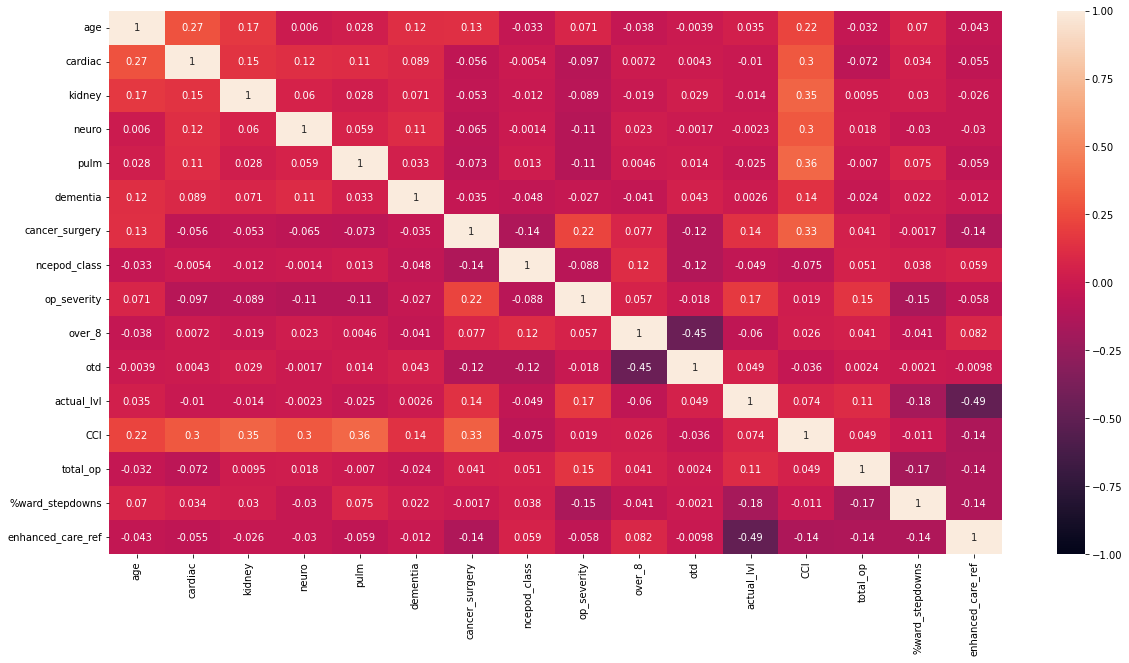

                           Logit Regression Results                           
Dep. Variable:                died_6m   No. Observations:                 5292
Model:                          Logit   Df Residuals:                     5274
Method:                           MLE   Df Model:                           17
Date:                Fri, 21 Mar 2025   Pseudo R-squ.:                 0.09374
Time:                        11:09:59   Log-Likelihood:                -611.97
converged:                       True   LL-Null:                       -675.27
Covariance Type:            nonrobust   LLR p-value:                 8.430e-19
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.3965      1.021     -5.284      0.000      -7.398      -3.395
age                   0.0209      0.007      2.932      0.003       0.007       0.035
cardiac               0.

In [38]:
dep_var = patient_nocancellations['died_6m']
dep_var = dep_var.fillna(0)
indep_var = patient_nocancellations[covars_died_6m].fillna(0)

for variable in covars_died_6m:
    temp_indep = sm.tools.tools.add_constant(patient_nocancellations[variable])
    temp_indep = temp_indep.fillna(0)
    temp_model = sm.discrete.discrete_model.Logit(dep_var, temp_indep).fit()
    print(temp_model.summary())

indep_var = sm.tools.tools.add_constant(indep_var)
model = sm.discrete.discrete_model.Logit(dep_var, indep_var).fit()
multicol(patient_dataset, indep_var)
print(model.summary())
print('AIC: '+str(model.aic))

## Updated multivariate models

### Creation of R dataset

In [39]:
drop_variables = list(['gender_male',
            'gender_non_binary',
            'asian',
            'black',
            'mixed',
            'white',
            'other',
            'surgical_speciality',
            'proposed_procedure',
            'scheduled_start',
            'previous_cancellation',
            'kts',
            'encounter_start',
            'encounter_end',
            'los_0',
            'los_1',
            'los_2',
            'los_3',
            'died_date',
            'critical_care_7_days',
            'cancel_other',
            'cancel_other_text',
            'score_text',
            'mortality_score',
            'morbidity_score',
            'other_reason',
            'refer_other_text',
            'proposed_lvl',
            'actual_lvl',
            'difference_nobed',
            'difference_other',
            'difference_other_text',
            'difference_unknown',
            'los_23',
            'los_recount',
            '1stepdowns',
            '1stepdowns_nobed',
            '23to0stepdowns',
            '23to0stepdowns_nobed',
            '23to1stepdowns',
            '23to1stepdowns_nobed',
            'ward_stepdowns',
            'ward_stepdowns_nobed',
            'level0-1_crit_care',
            'level0-1_crit_care_7d',
            'icb',
            'level_1',
            'num_level_1',
            'level_2',
            'level_3',
            'services',
            'mdt',
            'risk_score',
            'procedure_based',
            'clinical_judgement',
            'ref_anaes',
            'ref_surg',
            'ref_nurse',
            'ref_spr',
            'no_vetting',
            'vet_anaes',
            'vet_icu',
            'vet_surg',
            'vet_nurse',
            'alo_anaes',
            'alo_icu',
            'alo_surg',
            'alo_nurse',
            'bed_nurse',
            'nurse_bed_esc',
            'cover_cons',
            'cover_spr',
            'cover_sho',
            'clin_anaes',
            'clin_icu',
            'clin_surg',
            'discharge_anaes',
            'discharge_icu',
            'discharge_surg',
            'periph_vaso',
            'central_vaso',
            'cpap',
            'bipap',
            'stay_limit',
            'all_spec',
            'single_spec',
            'level_2_ring',
            'level_2_cap',
            'level_2_esc',
            'level_3_ring',
            'level_3_cap',
            'level_3_esc',
            'cancel_per_1000_total',
            'cancel_nobed_per_1000',
            'c_ref_lvl1',
            'c_plan_adm_lvl1',
            'c_adm_lvl1',
            'c_ref_lvl23',
            'c_plan_adm_lvl23',
            'c_adm_lvl23',
            'EhC_refs',
            'avg_age',
            '%female',
            '%white',
            '%BAME',
            '%asian',
            '%black',
            '%cardiac',
            '%kidney',
            '%liver',
            '%neuro',
            '%pulm',
            '%dementia',
            '%diabetes',
            '%comp_diabetes',
            '%htn',
            '%malignancy',
            '%metastasis',
            '%pvd',
            '%rheum',
            'avg_CCI',
            '%cancer_surgery',
            'avg_ncepod',
            'avg_severity',
            '%cancelled',
            '%cancelled_nobed',
            '%level0-1_crit_care',
            '%level0-1_crit_care_7d',
            'LOS_mean',
            'LOS_median',
            'LOS1_mean',
            'LOS1_median',
            'LOS23_mean',
            'LOS23_median',
            '%died',
            '%died_6m',
            '%clin_j',
            '%cpet',
            '%sop',
            '%risk_score',
            'pred_mortality',
            'pred_morbidity',
            '%_1_ref_over8',
            '%_1_ref_1_7',
            '%_1_ref_otd',
            '%_23_ref_over8',
            '%_23_ref_1_7',
            '%_23_ref_otd',
            '%1stepdowns',
            '%1stepdowns_nobed',
            '%23to0stepdowns',
            '%23to0stepdowns_nobed',
            '%23to1stepdowns',
            '%23to1stepdowns_nobed',
            '%ward_stepdowns_nobed',
                               ])

In [40]:
continuous_vars  = ['age',
                       'lvl_1_emer_adm',
                       'level_1_ring',
                       'level_1_cap',
                       'level_1_esc',
                       'level_23_ring',
                       'level_23_cap',
                       'level_23_esc',
                       'totalringcap',
                       'total_op',
                       'perc_day',
                       'surg_adm',
                       'perc_emerg',
                       'ref_lvl1_per_1000',
                       'plan_adm_lvl1_per_1000',
                       'adm_lvl1_per_1000',
                       'perc_emerg_lvl1',
                       'ref_lvl23_per_1000',
                       'plan_adm_lvl23_per_1000',
                       'adm_lvl23_per_1000',
                       'perc_emerg_lvl23',
                       'perc_ref_over8',
                       'perc_ref_1_7',
                       'perc_ref_otd',
                       'perc_ward_stepdowns',
                       'ref_to_cap_1',
                       'ref_to_cap_23']

In [ ]:
r_patient = patient_dataset.drop(columns=drop_variables)
hospital_name = r_patient.pop('hospital_name')
r_patient = r_patient.applymap(float)
r_patient['hospital_name'] = hospital_name
r_patient = r_patient.fillna(0).reset_index()
r_patient = r_patient.drop(columns='index')

#rename columns causing errors
r_patient.rename(columns={'over_8':'ref_over_8',
                          '1-7_days':'ref_1_7_days',
                          'otd':'ref_otd',
                          '%day':'perc_day',
                          '%emerg':'perc_emerg',
                          '%emerg_lvl1':'perc_emerg_lvl1',
                          '%emerg_lvl23':'perc_emerg_lvl23',
                          '%ref_over8':'perc_ref_over8',
                          '%ref_1_7':'perc_ref_1_7',
                          '%ref_otd':'perc_ref_otd',
                          '%ward_stepdowns':'perc_ward_stepdowns'}, inplace=True)

#scale variables to mean and variance
scaler = StandardScaler()
r_patient[continuous_vars] = scaler.fit_transform(r_patient[continuous_vars])

#convert age to cubic spline
spline_df = dmatrix("bs(age, df=3, degree=3, include_intercept=False)", 
                                  {"age": r_patient['age']}, return_type='dataframe')
spline_df.columns = [f'age_spline_{i+1}' for i in range(spline_df.shape[1])]
r_patient = pd.concat([r_patient, spline_df], axis=1)

display(r_patient)

In [52]:
plausible_covars = ['age',
                       'age_spline_1', 
                       'age_spline_2', 
                       'age_spline_3',
                       'age_spline_4',
                       'gender_female',
                       'cardiac',
                       'kidney',
                       'liver',
                       'neuro',
                       'pulm',
                       'dementia',
                       'diabetes',
                       'comp_diabetes',
                       'htn',
                       'malignancy',
                       'metastasis',
                       'pvd',
                       'rheum',
                       'cancer_surgery',
#                       'ncepod_class',
                       'op_severity',
                       'sop',
                       'cpet',
                       'clin_j',
                       'risk_score_patient',
                       'ref_over_8',
                       'ref_1_7_days',
                       'ref_otd',
                       'diabetes_uncomp',
                       'malignancy_no_met',
                       'BAME',
#                       'CCI',
                       'enhanced_care_ref',
#                       'enhanced_care_adm',
                       'type',
                       'em_dept',
                       'n_services',
                       'lvl_1_emer_adm',
                       'level_1_ring',
                       'level_1_cap',
                       'level_1_esc',
                       'level_23_ring',
                       'level_23_cap',
                       'level_23_esc',
                       'totalringcap',
                       'total_op',
                       'perc_day',
                       'surg_adm',
                       'perc_emerg',
                       'ref_lvl1_per_1000',
                       'plan_adm_lvl1_per_1000',
                       'adm_lvl1_per_1000',
                       'perc_emerg_lvl1',
                       'ref_lvl23_per_1000',
                       'plan_adm_lvl23_per_1000',
                       'adm_lvl23_per_1000',
                       'perc_emerg_lvl23',
                       'perc_ref_over8',
                       'perc_ref_1_7',
                       'perc_ref_otd',
                       'perc_ward_stepdowns',
                       'ref_to_cap_1',
                       'ref_to_cap_23'
                        ]

In [53]:
plausible_mortality_covars = ['age',
                       'age_spline_1', 
                       'age_spline_2', 
                       'age_spline_3',
                       'age_spline_4',
                       'gender_female',
                       'cardiac',
                       'kidney',
                       'liver',
                       'neuro',
                       'pulm',
                       'dementia',
                       'diabetes',
                       'comp_diabetes',
                       'htn',
                       'malignancy',
                       'metastasis',
                       'pvd',
                       'rheum',
                       'cancer_surgery',
#                       'ncepod_class',
                       'op_severity',
                       'sop',
                       'cpet',
                       'clin_j',
                       'risk_score_patient',
                       'ref_over_8',
                       'ref_1_7_days',
                       'ref_otd',
                       'diabetes_uncomp',
                       'malignancy_no_met',
                       'BAME',
#                       'CCI',
                       'enhanced_care_ref',
#                       'enhanced_care_adm',
                       'type',
                       'em_dept',
                       'n_services',
#                       'lvl_1_emer_adm',
#                       'level_1_ring',
#                       'level_1_cap',
#                       'level_1_esc',
#                       'level_23_ring',
#                       'level_23_cap',
#                       'level_23_esc',
#                       'totalringcap',
#                       'total_op',
#                       'perc_day',
#                       'surg_adm',
                       'perc_emerg',
                       'ref_lvl1_per_1000',
#                       'plan_adm_lvl1_per_1000',
                       'adm_lvl1_per_1000',
                       'perc_emerg_lvl1',
                       'ref_lvl23_per_1000',
#                       'plan_adm_lvl23_per_1000',
                       'adm_lvl23_per_1000',
                       'perc_emerg_lvl23',
#                       'perc_ref_over8',
#                       'perc_ref_1_7',
#                       'perc_ref_otd',
                       'perc_ward_stepdowns',
#                       'ref_to_cap_1',
#                       'ref_to_cap_23'
                        ]

In [43]:
r_patient.to_csv('r_patient.csv')

In [44]:
#R conversion for alternative method
#r_patient_conv = pandas2ri.py2rpy(r_patient)
#ro.globalenv['r_patient_conv'] = r_patient_conv

#specify which variables are categorical
#ro.r('r_patient_conv$gender_female <- as.factor(r_patient_conv$gender_female)')
#ro.r('r_patient_conv$BAME <- as.factor(r_patient_conv$BAME)')
#ro.r('r_patient_conv$hospital_name <- as.factor(r_patient_conv$hospital_name)')

#print(ro.r('str(r_patient_conv)'))
#print(ro.r('colnames(r_patient_conv)'))

### Models

In [56]:
#load dataset from file
r_patient = pd.read_csv("C:\\Users\\chris\\Documents\\Job Documents\\Portfolio Evidence\\Research\\Post-Operative Critical Care Beds Project\\IPYNB\\r_patient.csv", index_col=0)
display(r_patient)
scaler = StandardScaler()

,age,gender_female,cardiac,kidney,liver,neuro,pulm,dementia,diabetes,comp_diabetes,htn,malignancy,metastasis,pvd,rheum,cancer_surgery,ncepod_class,op_severity,cancelled,los_encounter,died,cancel_nobed,sop,cpet,clin_j,risk_score_patient,ref_over_8,ref_1_7_days,ref_otd,diabetes_uncomp,malignancy_no_met,BAME,CCI,enhanced_care_ref,enhanced_care_adm,died_6m,type,em_dept,n_services,lvl_1_emer_adm,level_1_ring,level_1_cap,level_1_esc,level_23_ring,level_23_cap,level_23_esc,totalringcap,total_op,perc_day,surg_adm,perc_emerg,ref_lvl1_per_1000,plan_adm_lvl1_per_1000,adm_lvl1_per_1000,perc_emerg_lvl1,ref_lvl23_per_1000,plan_adm_lvl23_per_1000,adm_lvl23_per_1000,perc_emerg_lvl23,perc_ref_over8,perc_ref_1_7,perc_ref_otd,perc_ward_stepdowns,ref_to_cap_1,ref_to_cap_23,hospital_name,age_spline_1,age_spline_2,age_spline_3,age_spline_4
0,-0.099442,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,4.0,-0.925277,0.342018,-0.489018,-0.538821,-0.564002,-1.419899,-1.454689,-0.091756,-0.929123,2.094340,-1.041021,-1.379057,1.374278,1.471195,1.219422,-0.753990,-1.036377,-1.012408,-1.384974,-1.538630,1.081994,-1.161255,-0.387209,-0.258769,-0.145024,-1.132759,Ashford Hospital,1.0,0.356785,0.391593,0.143266
1,-1.826227,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,4.0,-0.925277,0.342018,-0.489018,-0.538821,-0.564002,-1.419899,-1.454689,-0.091756,-0.929123,2.094340,-1.041021,-1.379057,1.374278,1.471195,1.219422,-0.753990,-1.036377,-1.012408,-1.384974,-1.538630,1.081994,-1.161255,-0.387209,-0.258769,-0.145024,-1.132759,Ashford Hospital,1.0,0.402281,0.114080,0.010784
2,-0.099442,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,4.0,-0.925277,0.342018,-0.489018,-0.538821,-0.564002,-1.419899,-1.454689,-0.091756,-0.929123,2.094340,-1.041021,-1.379057,1.374278,1.471195,1.219422,-0.753990,-1.036377,-1.012408,-1.384974,-1.538630,1.081994,-1.161255,-0.387209,-0.258769,-0.145024,-1.132759,Ashford Hospital,1.0,0.356785,0.391593,0.143266
3,1.760173,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,4.0,-0.925277,0.342018,-0.489018,-0.538821,-0.564002,-1.419899,-1.454689,-0.091756,-0.929123,2.094340,-1.041021,-1.379057,1.374278,1.471195,1.219422,-0.753990,-1.036377,-1.012408,-1.384974,-1.538630,1.081994,-1.161255,-0.387209,-0.258769,-0.145024,-1.132759,Ashford Hospital,1.0,0.058188,0.326750,0.611608
4,0.431876,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,20.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,2.0,0.0,4.0,-0.925277,0.342018,-0.489018,-0.538821,-0.564002,-1.419899,-1.454689,-0.091756,-0.929123,2.094340,-1.041021,-1.379057,1.374278,1.471195,1.219422,-0.753990,-1.036377,-1.012408,-1.384974,-1.538630,1.081994,-1.161255,-0.387209,-0.258769,-0.145024,-1.132759,Ashford Hospital,1.0,0.272226,0.437212,0.234063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5801,0.299047,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,7.0,1.080757,-0.690483,1.241829,1.151975,-0.564002,-0.737789,-0.835720,-0.901080,1.002874,1.702255,-0.112405,-0.543281,-0.487512,-0.429177,-0.284353,2.195044,-0.913026,-0.873951,-0.517110,1.246922,0.588737,-0.558721,-0.356256,-0.315726,-0.735402,-0.825036,York Hospital,1.0,0.294667,0.429373,0.208552
5802,-0.232272,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,4.0,0.0

In [55]:
#code used for variable selection, initial lasso regression followed by stepwise removal based on AIC
#this will take ~20hrs to run

#cancel_nobed_lasso = lasso_select('cancel_nobed', plausible_covars, r_patient, 0.5)
#cancel_nobed_final = stepwise_aic('cancel_nobed', cancel_nobed_lasso, r_patient, 20, 0.5)
#cancel_nobed_result = glmm_pymer4('cancel_nobed', cancel_nobed_final[2], r_patient)

#cancelled_lasso = lasso_select('cancelled', plausible_covars, r_patient, 0.5)
#cancelled_final = stepwise_aic('cancelled', cancelled_lasso, r_patient, 20, 0.5)
#cancelled_result = glmm_pymer4('cancelled', cancelled_final[2], r_patient)

#mortality_lasso = lasso_select('died_6m', plausible_mortality_covars, r_patient, 0.5)
#mortality_final = stepwise_aic('died_6m', mortality_lasso, r_patient, 20, 0.5)
#mortality_result = glmm_pymer4('died_6m', mortality_final[2], r_patient)

#los_lasso = lasso_select('los_encounter', plausible_covars, r_patient, 0.5)
#los_final = stepwise_aic_poisson('los_encounter', los_lasso, r_patient, 20, 0.5)
#los_result = poisson_pymer4('los_encounter', los_final[2], r_patient)


 Variance Inflation Factor ----
cardiac: 1.6119924898728808
kidney: 1.2069087885262277
pulm: 1.365363080957485
dementia: 1.0420505120511223
malignancy: 2.267638207898298
op_severity: 9.032700569264675
risk_score_patient: 1.7112365364435347
enhanced_care_ref: 3.497492055981005
type: 10.716423131886241
lvl_1_emer_adm: 6.058401323480593
level_1_ring: 8.652095840650622
level_1_cap: 4.679075547252756
totalringcap: 4.999770694430541
perc_day: 1.7297325284142997
adm_lvl1_per_1000: 3.451437792603026
ref_lvl23_per_1000: 2.10807212173779
perc_emerg_lvl23: 1.8686091840624433
perc_ref_otd: 1.412495768933407
perc_ward_stepdowns: 1.7171400217445552
ref_to_cap_1: 2.412282038112556


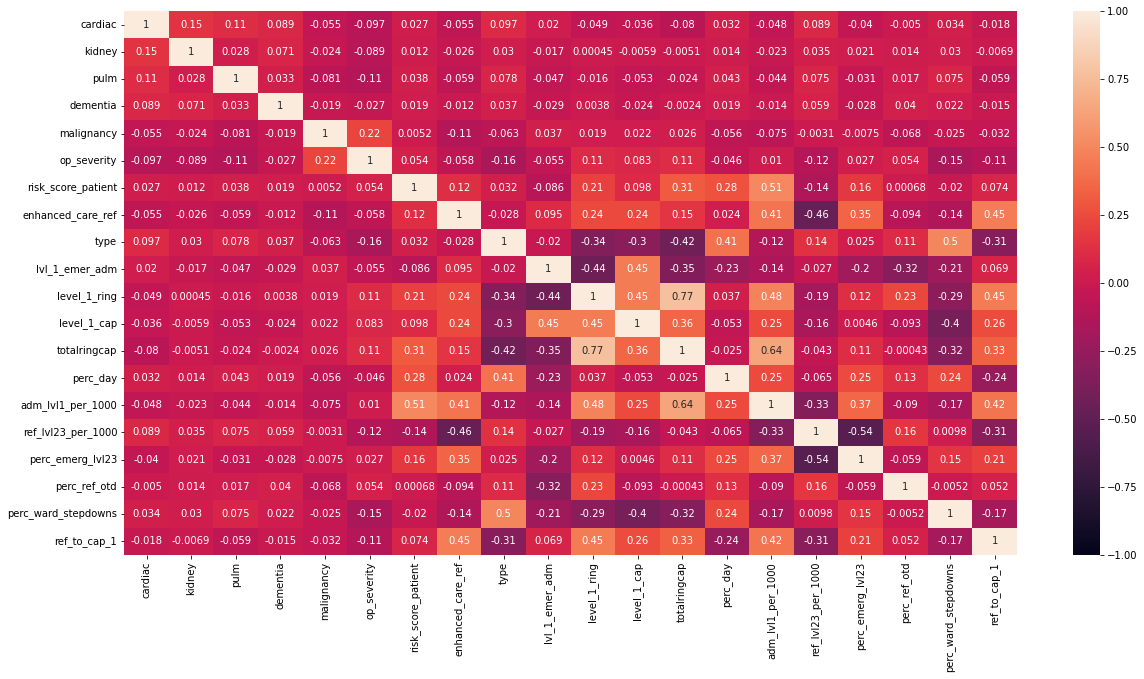

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: cancel_nobed~age+cardiac+kidney+pulm+dementia+malignancy+op_severity+risk_score_patient+enhanced_care_ref+type+lvl_1_emer_adm+level_1_ring+level_1_cap+totalringcap+perc_day+adm_lvl1_per_1000+ref_lvl23_per_1000+perc_emerg_lvl23+perc_ref_otd+perc_ward_stepdowns+ref_to_cap_1+(1|hospital_name)

Family: binomial	 Inference: parametric

Number of observations: 5806	 Groups: {'hospital_name': 60.0}

Log-likelihood: -713.964 	 AIC: 1473.928

Random effects:

                      Name  Var  Std
hospital_name  (Intercept)  0.0  0.0

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-2.790,-3.691,-1.889,0.460,0.061,0.025,0.151,0.058,0.024,0.131,-6.068,0.000,***
age,-0.101,-0.262,0.060,0.082,0.904,0.769,1.062,0.475,0.435,0.515,-1.230,0.219,
cardiac,0.458,0.123,0.794,0.171,1.581,1.131,2.212,0.613,0.531,0.689,2.677,0.007,**
kidney,0.295,-0.100,0.689,0.201,1.343,0.905,1.992,0.573,0.475,0.666,1.463,0.143,
pulm,0.376,0.051,0.702,0.166,1.457,1.052,2.017,0.593,0.513,0.669,2.265,0.024,*
dementia,0.826,-0.084,1.737,0.465,2.285,0.919,5.681,0.696,0.479,0.850,1.779,0.075,.
malignancy,-0.734,-1.075,-0.394,0.174,0.480,0.341,0.675,0.324,0.254,0.403,-4.224,0.000,***
op_severity,-0.229,-0.363,-0.096,0.068,0.795,0.696,0.909,0.443,0.410,0.476,-3.371,0.001,***
risk_score_patient,0.598,0.136,1.060,0.236,1.819,1.146,2.886,0.645,0.534,0.743,2.538,0.011,*
enhanced_care_ref,-1.539,-1.930,-1.149,0.199,0.215,0.145,0.317,0.177,0.127,0.241,-7.724,0.000,***


AUC-ROC: 0.778


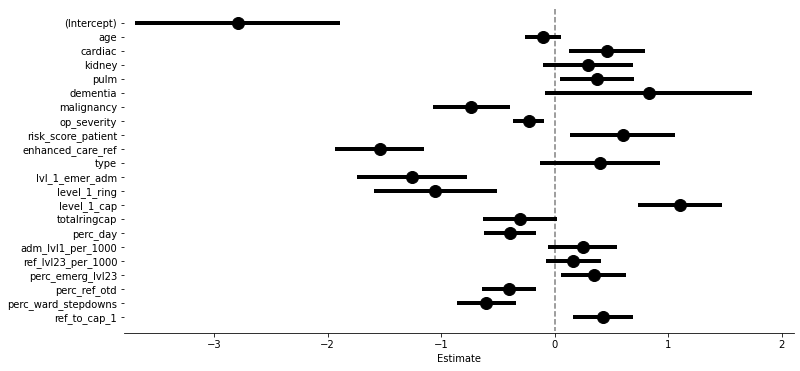

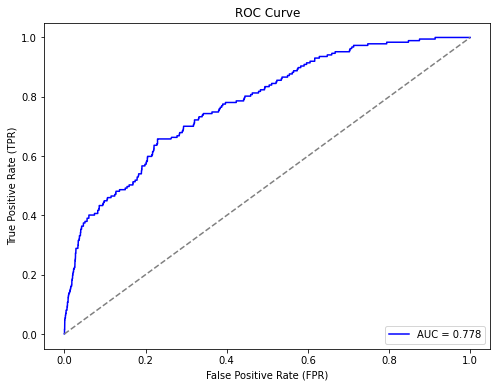

In [28]:
cancel_nobed_var = ['age',
                    'cardiac',
                    'kidney',
                    'pulm',
                    'dementia',
                    'malignancy',
                    'op_severity',
                    'risk_score_patient',
                    'enhanced_care_ref',
                    'type',
                    'lvl_1_emer_adm',
                    'level_1_ring',
                    'level_1_cap',
                    'totalringcap',
                    'perc_day',
                    'adm_lvl1_per_1000',
                    'ref_lvl23_per_1000',
                    'perc_emerg_lvl23',
                    'perc_ref_otd',
                    'perc_ward_stepdowns',
                    'ref_to_cap_1']

cancel_nobed_result = glmm_pymer4('cancel_nobed', cancel_nobed_var, r_patient)


 Variance Inflation Factor ----
liver: 1.085265336829038
neuro: 1.166774565685059
pulm: 1.3299430588066246
rheum: 1.1104503427219177
cancer_surgery: 3.0400656432495836
op_severity: 5.973569117095117
sop: 2.3639654492969444
ref_otd: 1.1747311568367085
malignancy_no_met: 2.4234729297574904
enhanced_care_ref: 2.712989500740149
lvl_1_emer_adm: 4.9856515616952155
level_1_ring: 5.892769975877008
level_1_cap: 4.47419377479967
perc_day: 1.2874828061838384
adm_lvl23_per_1000: 1.201044430931526
perc_ref_1_7: 1.4149022726564613
ref_to_cap_1: 2.5165565944027324


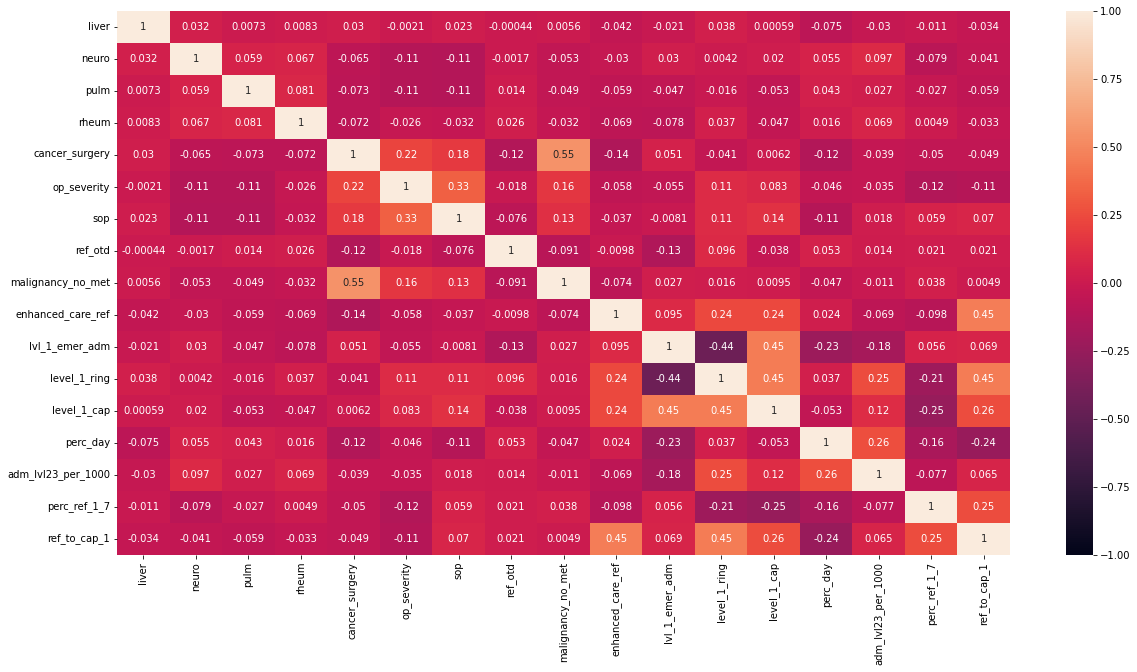

Model failed to converge with max|grad| = 0.0365035 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: cancelled~cardiac+liver+neuro+pulm+rheum+cancer_surgery+op_severity+sop+ref_otd+malignancy_no_met+enhanced_care_ref+lvl_1_emer_adm+level_1_ring+level_1_cap+perc_day+adm_lvl23_per_1000+perc_ref_1_7+ref_to_cap_1+(1|hospital_name)

Family: binomial	 Inference: parametric

Number of observations: 5806	 Groups: {'hospital_name': 60.0}

Log-likelihood: -1618.093 	 AIC: 3276.186

Random effects:

                      Name    Var    Std
hospital_name  (Intercept)  0.342  0.585

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.302,-1.750,-0.854,0.229,0.272,0.174,0.426,0.214,0.148,0.299,-5.694,0.000,***
cardiac,0.398,0.200,0.595,0.101,1.488,1.221,1.814,0.598,0.550,0.645,3.938,0.000,***
liver,0.328,-0.024,0.679,0.179,1.388,0.977,1.972,0.581,0.494,0.664,1.827,0.068,.
neuro,0.181,-0.099,0.461,0.143,1.199,0.906,1.586,0.545,0.475,0.613,1.270,0.204,
pulm,0.134,-0.076,0.343,0.107,1.143,0.927,1.410,0.533,0.481,0.585,1.251,0.211,
rheum,-0.424,-0.803,-0.046,0.193,0.654,0.448,0.955,0.395,0.309,0.489,-2.197,0.028,*
cancer_surgery,-0.361,-0.607,-0.115,0.126,0.697,0.545,0.892,0.411,0.353,0.471,-2.872,0.004,**
op_severity,-0.131,-0.220,-0.042,0.045,0.877,0.802,0.959,0.467,0.445,0.490,-2.879,0.004,**
sop,-0.494,-0.717,-0.270,0.114,0.610,0.488,0.763,0.379,0.328,0.433,-4.332,0.000,***
ref_otd,-0.331,-0.655,-0.007,0.165,0.718,0.519,0.993,0.418,0.342,0.498,-2.004,0.045,*


AUC-ROC: 0.730


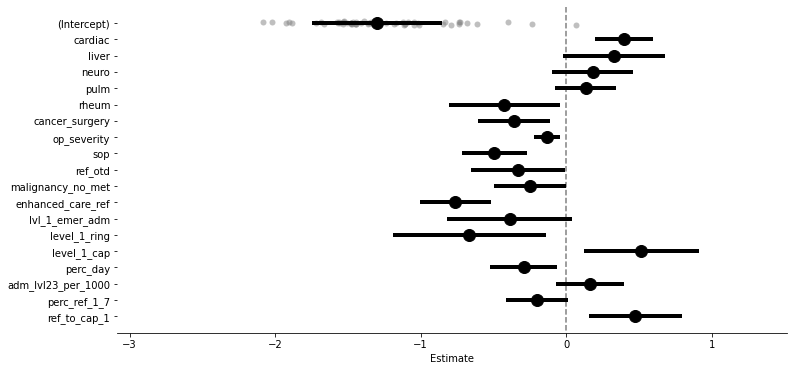

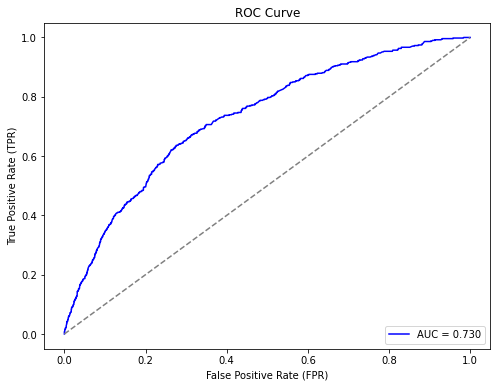

In [102]:
cancelled_var = ['cardiac',
                 'liver',
                 'neuro',
                 'pulm',
                 'rheum',
                 'cancer_surgery',
                 'op_severity',
                 'sop',
                 'ref_otd',
                 'malignancy_no_met',
                 'enhanced_care_ref',
                 'lvl_1_emer_adm',
                 'level_1_ring',
                 'level_1_cap',
                 'perc_day',
                 'adm_lvl23_per_1000',
                 'perc_ref_1_7',
                 'ref_to_cap_1']
cancelled_result = glmm_pymer4('cancelled', cancelled_var, r_patient)

In [104]:
r_patient_mortality = r_patient[r_patient['cancelled'] != 1]
display(r_patient_mortality)

,age,gender_female,cardiac,kidney,liver,neuro,pulm,dementia,diabetes,comp_diabetes,htn,malignancy,metastasis,pvd,rheum,cancer_surgery,ncepod_class,op_severity,cancelled,los_encounter,died,cancel_nobed,sop,cpet,clin_j,risk_score_patient,ref_over_8,ref_1_7_days,ref_otd,diabetes_uncomp,malignancy_no_met,BAME,CCI,enhanced_care_ref,enhanced_care_adm,died_6m,type,em_dept,n_services,lvl_1_emer_adm,level_1_ring,level_1_cap,level_1_esc,level_23_ring,level_23_cap,level_23_esc,totalringcap,total_op,perc_day,surg_adm,perc_emerg,ref_lvl1_per_1000,plan_adm_lvl1_per_1000,adm_lvl1_per_1000,perc_emerg_lvl1,ref_lvl23_per_1000,plan_adm_lvl23_per_1000,adm_lvl23_per_1000,perc_emerg_lvl23,perc_ref_over8,perc_ref_1_7,perc_ref_otd,perc_ward_stepdowns,ref_to_cap_1,ref_to_cap_23,hospital_name,age_spline_1,age_spline_2,age_spline_3,age_spline_4
0,-0.099442,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,4.0,-0.925277,0.342018,-0.489018,-0.538821,-0.564002,-1.419899,-1.454689,-0.091756,-0.929123,2.094340,-1.041021,-1.379057,1.374278,1.471195,1.219422,-0.753990,-1.036377,-1.012408,-1.384974,-1.538630,1.081994,-1.161255,-0.387209,-0.258769,-0.145024,-1.132759,Ashford Hospital,1.0,0.356785,0.391593,0.143266
1,-1.826227,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,4.0,-0.925277,0.342018,-0.489018,-0.538821,-0.564002,-1.419899,-1.454689,-0.091756,-0.929123,2.094340,-1.041021,-1.379057,1.374278,1.471195,1.219422,-0.753990,-1.036377,-1.012408,-1.384974,-1.538630,1.081994,-1.161255,-0.387209,-0.258769,-0.145024,-1.132759,Ashford Hospital,1.0,0.402281,0.114080,0.010784
2,-0.099442,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,4.0,-0.925277,0.342018,-0.489018,-0.538821,-0.564002,-1.419899,-1.454689,-0.091756,-0.929123,2.094340,-1.041021,-1.379057,1.374278,1.471195,1.219422,-0.753990,-1.036377,-1.012408,-1.384974,-1.538630,1.081994,-1.161255,-0.387209,-0.258769,-0.145024,-1.132759,Ashford Hospital,1.0,0.356785,0.391593,0.143266
3,1.760173,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,4.0,-0.925277,0.342018,-0.489018,-0.538821,-0.564002,-1.419899,-1.454689,-0.091756,-0.929123,2.094340,-1.041021,-1.379057,1.374278,1.471195,1.219422,-0.753990,-1.036377,-1.012408,-1.384974,-1.538630,1.081994,-1.161255,-0.387209,-0.258769,-0.145024,-1.132759,Ashford Hospital,1.0,0.058188,0.326750,0.611608
4,0.431876,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,20.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,2.0,0.0,4.0,-0.925277,0.342018,-0.489018,-0.538821,-0.564002,-1.419899,-1.454689,-0.091756,-0.929123,2.094340,-1.041021,-1.379057,1.374278,1.471195,1.219422,-0.753990,-1.036377,-1.012408,-1.384974,-1.538630,1.081994,-1.161255,-0.387209,-0.258769,-0.145024,-1.132759,Ashford Hospital,1.0,0.272226,0.437212,0.234063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5801,0.299047,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,7.0,1.080757,-0.690483,1.241829,1.151975,-0.564002,-0.737789,-0.835720,-0.901080,1.002874,1.702255,-0.112405,-0.543281,-0.487512,-0.429177,-0.284353,2.195044,-0.913026,-0.873951,-0.517110,1.246922,0.588737,-0.558721,-0.356256,-0.315726,-0.735402,-0.825036,York Hospital,1.0,0.294667,0.429373,0.208552
5802,-0.232272,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,4.0,0.0


 Variance Inflation Factor ----
age_spline_2: 4.655731904519846
age_spline_3: 2.375465555310347
age_spline_4: 7.201252593523317
cardiac: 1.1418582730910487
kidney: 1.057516732421667
neuro: 1.066811184379682
dementia: 1.049278086795908
malignancy: 1.3094510558028654
metastasis: 1.1491397966497061
pvd: 1.0734567950805105
sop: 1.089089978637018
cpet: 1.0752727913499827
ref_over_8: 1.2998967356433972
ref_otd: 1.2910330936006376
enhanced_care_ref: 1.3423926747698793
em_dept: 1.0702481806221438
ref_lvl23_per_1000: 1.3392375809344348
perc_ward_stepdowns: 1.0715408545069658


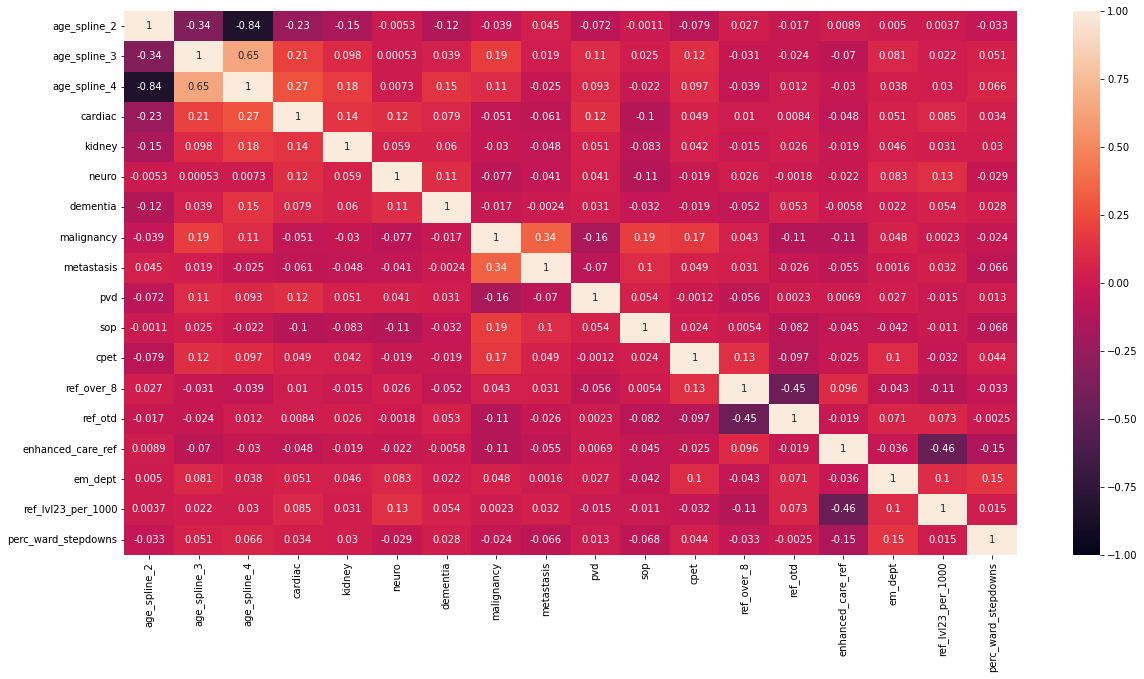

Model failed to converge with max|grad| = 0.00582032 (tol = 0.002, component 1) 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: died_6m~age_spline_1+age_spline_2+age_spline_3+age_spline_4+cardiac+kidney+neuro+dementia+malignancy+metastasis+pvd+sop+cpet+ref_over_8+ref_otd+enhanced_care_ref+em_dept+ref_lvl23_per_1000+perc_ward_stepdowns+(1|hospital_name)

Family: binomial	 Inference: parametric

Number of observations: 5292	 Groups: {'hospital_name': 60.0}

Log-likelihood: -599.110 	 AIC: 1238.221

Random effects:

                      Name   Var    Std
hospital_name  (Intercept)  0.31  0.557

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-5.917,-8.062,-3.772,1.094,0.003,0.000,0.023,0.003,0.000,0.022,-5.406,0.000,***
age_spline_2,-1.932,-6.541,2.678,2.352,0.145,0.001,14.558,0.127,0.001,0.936,-0.821,0.411,
age_spline_3,4.256,1.353,7.158,1.481,70.513,3.871,1284.531,0.986,0.795,0.999,2.874,0.004,**
age_spline_4,-1.493,-5.459,2.473,2.023,0.225,0.004,11.853,0.183,0.004,0.922,-0.738,0.461,
cardiac,0.317,-0.054,0.688,0.189,1.373,0.948,1.989,0.579,0.487,0.665,1.675,0.094,.
kidney,0.429,-0.003,0.860,0.220,1.535,0.997,2.364,0.606,0.499,0.703,1.947,0.052,.
neuro,0.506,0.025,0.987,0.245,1.658,1.025,2.683,0.624,0.506,0.728,2.062,0.039,*
dementia,0.831,-0.125,1.786,0.487,2.295,0.883,5.966,0.696,0.469,0.856,1.704,0.088,.
malignancy,0.585,0.163,1.006,0.215,1.795,1.177,2.736,0.642,0.541,0.732,2.720,0.007,**
metastasis,0.928,0.504,1.351,0.216,2.528,1.656,3.860,0.717,0.623,0.794,4.296,0.000,***


AUC-ROC: 0.804


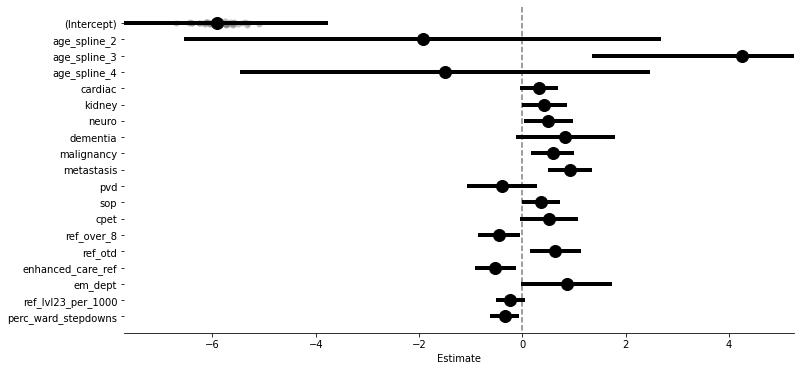

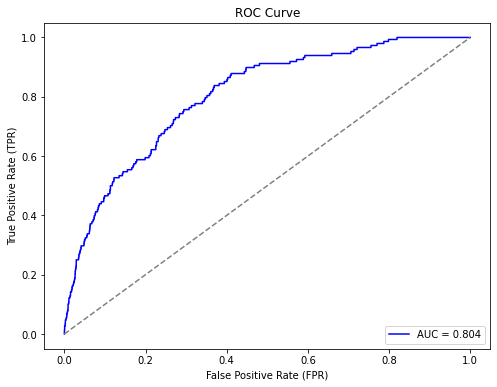

In [107]:
mortality_var = ['age_spline_1', 
                 'age_spline_2', 
                 'age_spline_3',
                 'age_spline_4',
                 'cardiac', 
                 'kidney', 
                 'neuro', 
                 'dementia', 
                 'malignancy', 
                 'metastasis', 
                 'pvd', 
                 'sop', 
                 'cpet', 
                 'ref_over_8', 
                 'ref_otd', 
                 'enhanced_care_ref', 
                 'em_dept', 
                 'ref_lvl23_per_1000', 
                 'perc_ward_stepdowns']
mortality_result = glmm_pymer4('died_6m', mortality_var, r_patient_mortality)

In [61]:
r_patient_los = r_patient[(r_patient['cancelled'] != 1) & (r_patient['los_encounter'] > 0) & (r_patient['los_encounter'] < 100)]
r_patient_los['los_encounter'] = r_patient_los['los_encounter'].map(round)
display(r_patient_los)

C:\Users\chris\AppData\Local\Temp\ipykernel_2568\3509456846.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_patient_los['los_encounter'] = r_patient_los['los_encounter'].map(round)


,age,gender_female,cardiac,kidney,liver,neuro,pulm,dementia,diabetes,comp_diabetes,htn,malignancy,metastasis,pvd,rheum,cancer_surgery,ncepod_class,op_severity,cancelled,los_encounter,died,cancel_nobed,sop,cpet,clin_j,risk_score_patient,ref_over_8,ref_1_7_days,ref_otd,diabetes_uncomp,malignancy_no_met,BAME,CCI,enhanced_care_ref,enhanced_care_adm,died_6m,type,em_dept,n_services,lvl_1_emer_adm,level_1_ring,level_1_cap,level_1_esc,level_23_ring,level_23_cap,level_23_esc,totalringcap,total_op,perc_day,surg_adm,perc_emerg,ref_lvl1_per_1000,plan_adm_lvl1_per_1000,adm_lvl1_per_1000,perc_emerg_lvl1,ref_lvl23_per_1000,plan_adm_lvl23_per_1000,adm_lvl23_per_1000,perc_emerg_lvl23,perc_ref_over8,perc_ref_1_7,perc_ref_otd,perc_ward_stepdowns,ref_to_cap_1,ref_to_cap_23,hospital_name,age_spline_1,age_spline_2,age_spline_3,age_spline_4
0,-0.099442,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,4.0,-0.925277,0.342018,-0.489018,-0.538821,-0.564002,-1.419899,-1.454689,-0.091756,-0.929123,2.094340,-1.041021,-1.379057,1.374278,1.471195,1.219422,-0.753990,-1.036377,-1.012408,-1.384974,-1.538630,1.081994,-1.161255,-0.387209,-0.258769,-0.145024,-1.132759,Ashford Hospital,1.0,0.356785,0.391593,0.143266
1,-1.826227,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,4.0,-0.925277,0.342018,-0.489018,-0.538821,-0.564002,-1.419899,-1.454689,-0.091756,-0.929123,2.094340,-1.041021,-1.379057,1.374278,1.471195,1.219422,-0.753990,-1.036377,-1.012408,-1.384974,-1.538630,1.081994,-1.161255,-0.387209,-0.258769,-0.145024,-1.132759,Ashford Hospital,1.0,0.402281,0.114080,0.010784
2,-0.099442,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,6,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,4.0,-0.925277,0.342018,-0.489018,-0.538821,-0.564002,-1.419899,-1.454689,-0.091756,-0.929123,2.094340,-1.041021,-1.379057,1.374278,1.471195,1.219422,-0.753990,-1.036377,-1.012408,-1.384974,-1.538630,1.081994,-1.161255,-0.387209,-0.258769,-0.145024,-1.132759,Ashford Hospital,1.0,0.356785,0.391593,0.143266
3,1.760173,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,4.0,-0.925277,0.342018,-0.489018,-0.538821,-0.564002,-1.419899,-1.454689,-0.091756,-0.929123,2.094340,-1.041021,-1.379057,1.374278,1.471195,1.219422,-0.753990,-1.036377,-1.012408,-1.384974,-1.538630,1.081994,-1.161255,-0.387209,-0.258769,-0.145024,-1.132759,Ashford Hospital,1.0,0.058188,0.326750,0.611608
4,0.431876,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,20,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,2.0,0.0,4.0,-0.925277,0.342018,-0.489018,-0.538821,-0.564002,-1.419899,-1.454689,-0.091756,-0.929123,2.094340,-1.041021,-1.379057,1.374278,1.471195,1.219422,-0.753990,-1.036377,-1.012408,-1.384974,-1.538630,1.081994,-1.161255,-0.387209,-0.258769,-0.145024,-1.132759,Ashford Hospital,1.0,0.272226,0.437212,0.234063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5801,0.299047,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,7.0,1.080757,-0.690483,1.241829,1.151975,-0.564002,-0.737789,-0.835720,-0.901080,1.002874,1.702255,-0.112405,-0.543281,-0.487512,-0.429177,-0.284353,2.195044,-0.913026,-0.873951,-0.517110,1.246922,0.588737,-0.558721,-0.356256,-0.315726,-0.735402,-0.825036,York Hospital,1.0,0.294667,0.429373,0.208552
5802,-0.232272,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,4,0.0,0.0,1.0,0.0,0


 Variance Inflation Factor ----
gender_female: 1.8074755561034868
cardiac: 1.6148259389481419
kidney: 1.246661403276544
liver: 1.090959960176503
neuro: 1.1760708594801024
pulm: 1.3516941312919102
comp_diabetes: 1.283346326732839
diabetes: 1.581416437331028
htn: 2.2108902792239915
metastasis: 1.292814087456845
malignancy: 4.391551268008509
pvd: 1.2307572184185354
rheum: 1.130433558371391
cancer_surgery: 4.082363557222016
op_severity: 8.725109456061379
sop: 2.3627637606535594
cpet: 1.1762391106376031
risk_score_patient: 1.3727047997871715
ref_over_8: 4.677507389084605
ref_1_7_days: 2.7758973202182076
enhanced_care_ref: 2.910324129787145
lvl_1_emer_adm: 1.4362094262200316
level_1_ring: 1.762171728708909
perc_ref_1_7: 1.408950882264826
ref_to_cap_23: 1.454548512878951


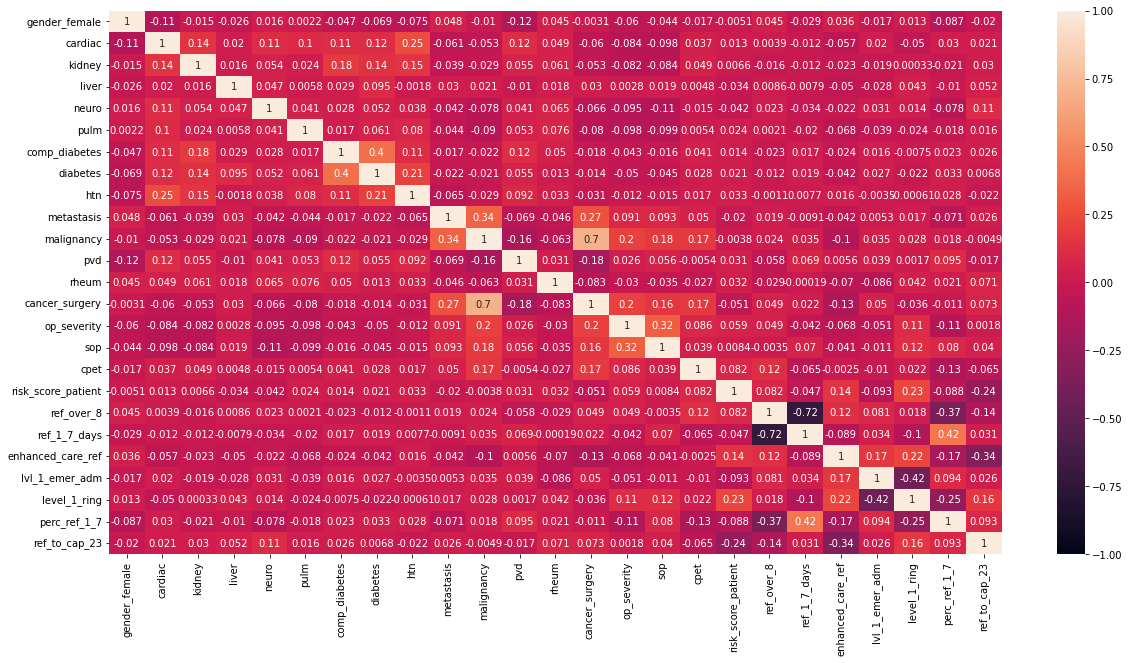

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: los_encounter~age+gender_female+cardiac+kidney+liver+neuro+pulm+comp_diabetes+diabetes+htn+metastasis+malignancy+pvd+rheum+cancer_surgery+op_severity+sop+cpet+risk_score_patient+ref_over_8+ref_1_7_days+enhanced_care_ref+lvl_1_emer_adm+level_1_ring+perc_ref_1_7+ref_to_cap_23+(1|hospital_name)

Family: poisson	 Inference: parametric

Number of observations: 4966	 Groups: {'hospital_name': 59.0}

Log-likelihood: -27804.257 	 AIC: 55664.513

Random effects:

                      Name   Var    Std
hospital_name  (Intercept)  0.12  0.347

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,Z-stat,P-val,Sig
(Intercept),2.281,2.147,2.414,0.068,33.579,0.000,***
age,0.089,0.078,0.100,0.006,16.068,0.000,***
gender_female,-0.009,-0.028,0.010,0.010,-0.910,0.363,
cardiac,-0.036,-0.058,-0.014,0.011,-3.199,0.001,**
kidney,-0.027,-0.056,0.001,0.014,-1.894,0.058,.
liver,-0.039,-0.078,-0.001,0.020,-1.988,0.047,*
neuro,-0.041,-0.074,-0.008,0.017,-2.439,0.015,*
pulm,-0.136,-0.159,-0.114,0.012,-11.675,0.000,***
comp_diabetes,0.054,0.006,0.102,0.025,2.188,0.029,*
diabetes,0.066,0.042,0.090,0.012,5.364,0.000,***


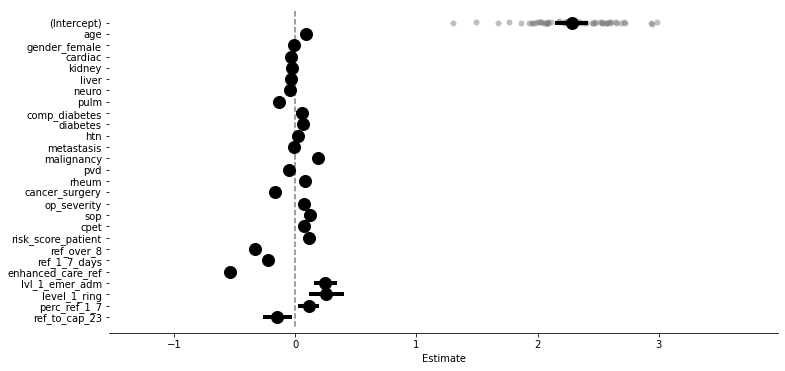

In [98]:
los_var = ['age', 
           'gender_female', 
           'cardiac',
           'kidney', 
           'liver', 
           'neuro', 
           'pulm', 
           'comp_diabetes',
           'diabetes',
           'htn', 
           'metastasis', 
           'malignancy',
           'pvd', 
           'rheum', 
           'cancer_surgery', 
           'op_severity', 
           'sop', 
           'cpet', 
           'risk_score_patient', 
           'ref_over_8', 
           'ref_1_7_days', 
           'enhanced_care_ref', 
           'lvl_1_emer_adm', 
           'level_1_ring', 
           'perc_ref_1_7',  
           'ref_to_cap_23']
los_result = poisson_pymer4('los_encounter', los_var, r_patient_los)